In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn import tree
from graphviz import Source
from IPython.display import display
from IPython.display import SVG

## Creating synthetic dataset
We will create a synthetic dataset with two classes. The dataset will be hard to distinguish based on statistical features, but possible with proper prototypical parts extracted.

We are making it even harder, as the prototypical parts are more or less the same. They are differing in terms of frequency.

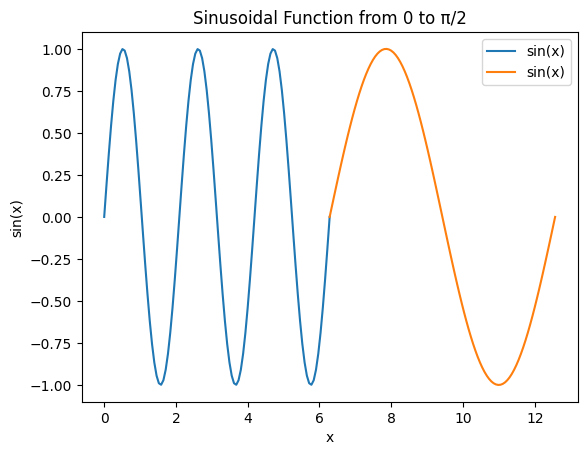

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to π/2
x1 = np.linspace(0, 2*np.pi, 100)
x2 = np.linspace(2*np.pi, 4*np.pi, 100)

# Calculate y values for the sinusoidal function
y1 = np.sin(3*x1)
y2 = np.sin(x2)

# Plotting the sinusoidal function
plt.plot(x1, y1, label='sin(x)')
plt.plot(x2, y2, label='sin(x)')
plt.title('Sinusoidal Function from 0 to π/2')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

In [5]:
X3 = np.concatenate((x1,x2))
Y3 = np.concatenate((y1,y2))

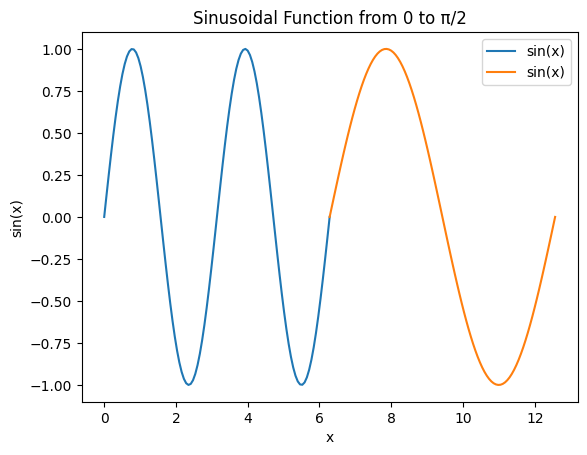

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to π/2
x1 = np.linspace(0, 2*np.pi, 100)
x2 = np.linspace(2*np.pi, 4*np.pi, 100)

# Calculate y values for the sinusoidal function
y1 = np.sin(2*x1)
y2 = np.sin(x2)

# Plotting the sinusoidal function
plt.plot(x1, y1, label='sin(x)')
plt.plot(x2, y2, label='sin(x)')
plt.title('Sinusoidal Function from 0 to π/2')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

In [7]:
X4 = np.concatenate((x1,x2))
Y4 = np.concatenate((y1,y2))

## Generating sample cases

In [8]:
x = X3
proto_sin_y = Y3
proto_inversed_sin_y = Y4

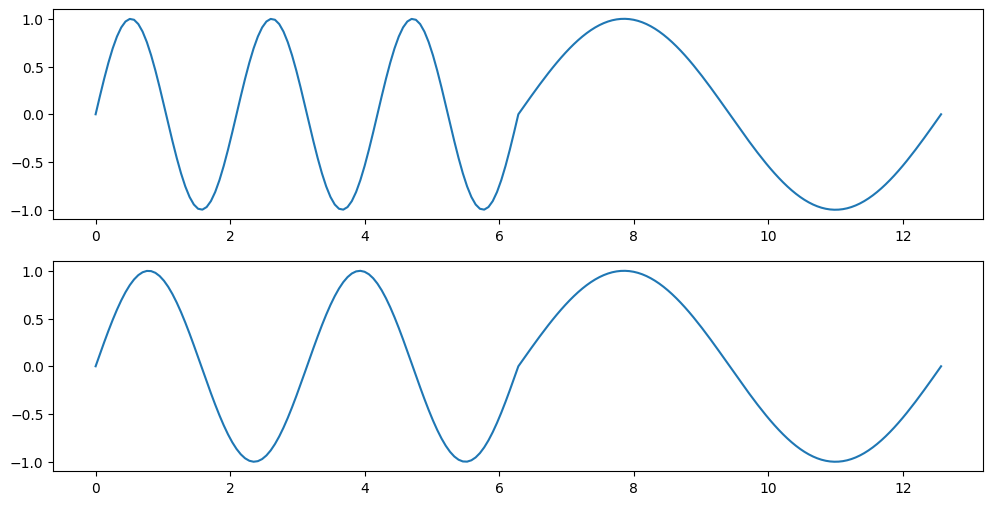

In [9]:
fig, axes =plt.subplots(2,1,figsize=(12,6))
axes[0].plot(x,proto_sin_y)
axes[1].plot(x,proto_inversed_sin_y)

## Generating noise and augmenting signals

In [10]:
noise_power = .2

In [11]:
noise = (np.random.rand(100,len(x))-0.5)*noise_power
noisy_proto_sin_y = noise + proto_sin_y

In [12]:
noise = (np.random.rand(100,len(x))-0.5)*noise_power
noisy_proto_inversed_sin_y = noise + proto_inversed_sin_y

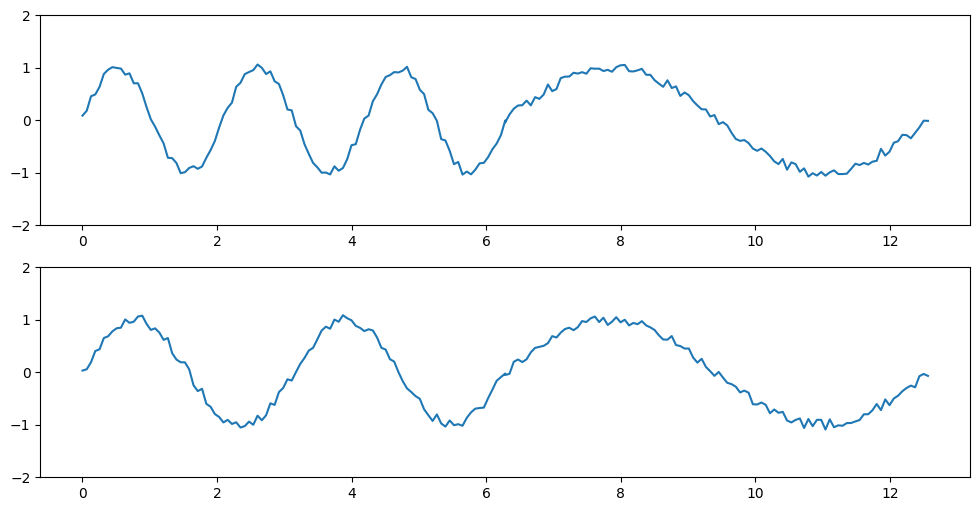

In [13]:
fig, axes =plt.subplots(2,1,figsize=(12,6))
axes[0].plot(x,noisy_proto_sin_y[0])
axes[1].plot(x,noisy_proto_inversed_sin_y[0])
for ax in axes:
    ax.set_ylim([-2, 2])

In [14]:
X=np.concatenate((noisy_proto_sin_y,noisy_proto_inversed_sin_y))
Xy=np.concatenate((np.ones(len(noisy_proto_sin_y))*0,
                   np.ones(len(noisy_proto_inversed_sin_y))*1))

trainX, testX, train_y,test_y = train_test_split(X,Xy)

## Model
We will build simple DNN model (not really needed in this case, but it serves the purpose of demonstration how to deal with more complex cases)

In [15]:
trainX.shape

(150, 200)

In [16]:
from keras.utils import to_categorical
trainXnn = trainX.reshape(150,1,200)
train_ynn = to_categorical(train_y)
num_classes = len(np.unique(Xy))

In [17]:
import keras
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    #add dropout
    input_layer = keras.layers.Dropout(0.5)(input_layer)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(input_layer)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)



model = make_model(input_shape=trainXnn.shape[1:])

In [18]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_crossentropy"],
)
history = model.fit(
    trainXnn,
    train_ynn,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - categorical_crossentropy: 0.6888 - loss: 0.6888

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 590ms/step - categorical_crossentropy: 0.6881 - loss: 0.6881 - val_categorical_crossentropy: 0.6666 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 2/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - categorical_crossentropy: 0.6677 - loss: 0.6677

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 0.6579 - loss: 0.6579 - val_categorical_crossentropy: 0.6119 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 3/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 0.6163 - loss: 0.6163

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 0.5952 - loss: 0.5952 - val_categorical_crossentropy: 0.5113 - val_loss: 0.5113 - learning_rate: 0.0010
Epoch 4/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 0.5112 - loss: 0.5112

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 0.4821 - loss: 0.4821 - val_categorical_crossentropy: 0.3618 - val_loss: 0.3618 - learning_rate: 0.0010
Epoch 5/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 0.3648 - loss: 0.3648

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 0.3275 - loss: 0.3275 - val_categorical_crossentropy: 0.1932 - val_loss: 0.1932 - learning_rate: 0.0010
Epoch 6/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 0.1999 - loss: 0.1999

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 0.1663 - loss: 0.1663 - val_categorical_crossentropy: 0.0701 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 7/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_crossentropy: 0.0721 - loss: 0.0721

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 0.0562 - loss: 0.0562 - val_categorical_crossentropy: 0.0181 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 8/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 0.0188 - loss: 0.0188

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 0.0144 - loss: 0.0144 - val_categorical_crossentropy: 0.0044 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 9/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_crossentropy: 0.0044 - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 0.0034 - loss: 0.0034 - val_categorical_crossentropy: 0.0012 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 10/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 0.0012 - loss: 0.0012

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 9.6529e-04 - loss: 9.6529e-04 - val_categorical_crossentropy: 4.2505e-04 - val_loss: 4.2505e-04 - learning_rate: 0.0010
Epoch 11/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 4.1545e-04 - loss: 4.1545e-04

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 3.5167e-04 - loss: 3.5167e-04 - val_categorical_crossentropy: 1.9056e-04 - val_loss: 1.9056e-04 - learning_rate: 0.0010
Epoch 12/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.8087e-04 - loss: 1.8087e-04

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6140e-04 - loss: 1.6140e-04 - val_categorical_crossentropy: 1.0567e-04 - val_loss: 1.0567e-04 - learning_rate: 0.0010
Epoch 13/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0134e-04 - loss: 1.0134e-04

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 9.2719e-05 - loss: 9.2719e-05 - val_categorical_crossentropy: 6.9191e-05 - val_loss: 6.9191e-05 - learning_rate: 0.0010
Epoch 14/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 6.4527e-05 - loss: 6.4527e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 6.2026e-05 - loss: 6.2026e-05 - val_categorical_crossentropy: 5.1227e-05 - val_loss: 5.1227e-05 - learning_rate: 0.0010
Epoch 15/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 4.8044e-05 - loss: 4.8044e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 4.6473e-05 - loss: 4.6473e-05 - val_categorical_crossentropy: 4.1468e-05 - val_loss: 4.1468e-05 - learning_rate: 0.0010
Epoch 16/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 3.9476e-05 - loss: 3.9476e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 3.8300e-05 - loss: 3.8300e-05 - val_categorical_crossentropy: 3.5754e-05 - val_loss: 3.5754e-05 - learning_rate: 0.0010
Epoch 17/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 3.1251e-05 - loss: 3.1251e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 3.2405e-05 - loss: 3.2405e-05 - val_categorical_crossentropy: 3.2234e-05 - val_loss: 3.2234e-05 - learning_rate: 0.0010
Epoch 18/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 3.0417e-05 - loss: 3.0417e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 3.0321e-05 - loss: 3.0321e-05 - val_categorical_crossentropy: 2.9933e-05 - val_loss: 2.9933e-05 - learning_rate: 0.0010
Epoch 19/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 2.8476e-05 - loss: 2.8476e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.8213e-05 - loss: 2.8213e-05 - val_categorical_crossentropy: 2.8403e-05 - val_loss: 2.8403e-05 - learning_rate: 0.0010
Epoch 20/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.7969e-05 - loss: 2.7969e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.7112e-05 - loss: 2.7112e-05 - val_categorical_crossentropy: 2.7342e-05 - val_loss: 2.7342e-05 - learning_rate: 0.0010
Epoch 21/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 2.6594e-05 - loss: 2.6594e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.6007e-05 - loss: 2.6007e-05 - val_categorical_crossentropy: 2.6607e-05 - val_loss: 2.6607e-05 - learning_rate: 0.0010
Epoch 22/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.5436e-05 - loss: 2.5436e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.5327e-05 - loss: 2.5327e-05 - val_categorical_crossentropy: 2.6043e-05 - val_loss: 2.6043e-05 - learning_rate: 0.0010
Epoch 23/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.4169e-05 - loss: 2.4169e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 2.4700e-05 - loss: 2.4700e-05 - val_categorical_crossentropy: 2.5598e-05 - val_loss: 2.5598e-05 - learning_rate: 0.0010
Epoch 24/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.4192e-05 - loss: 2.4192e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 2.4333e-05 - loss: 2.4333e-05 - val_categorical_crossentropy: 2.5240e-05 - val_loss: 2.5240e-05 - learning_rate: 0.0010
Epoch 25/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.3450e-05 - loss: 2.3450e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.3928e-05 - loss: 2.3928e-05 - val_categorical_crossentropy: 2.4930e-05 - val_loss: 2.4930e-05 - learning_rate: 0.0010
Epoch 26/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.1018e-05 - loss: 2.1018e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 2.3067e-05 - loss: 2.3067e-05 - val_categorical_crossentropy: 2.4680e-05 - val_loss: 2.4680e-05 - learning_rate: 0.0010
Epoch 27/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.4054e-05 - loss: 2.4054e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 2.3761e-05 - loss: 2.3761e-05 - val_categorical_crossentropy: 2.4453e-05 - val_loss: 2.4453e-05 - learning_rate: 0.0010
Epoch 28/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.2463e-05 - loss: 2.2463e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 2.2978e-05 - loss: 2.2978e-05 - val_categorical_crossentropy: 2.4215e-05 - val_loss: 2.4215e-05 - learning_rate: 0.0010
Epoch 29/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 2.3529e-05 - loss: 2.3529e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.3114e-05 - loss: 2.3114e-05 - val_categorical_crossentropy: 2.4000e-05 - val_loss: 2.4000e-05 - learning_rate: 0.0010
Epoch 30/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.2284e-05 - loss: 2.2284e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.2709e-05 - loss: 2.2709e-05 - val_categorical_crossentropy: 2.3798e-05 - val_loss: 2.3798e-05 - learning_rate: 0.0010
Epoch 31/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.3517e-05 - loss: 2.3517e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.2989e-05 - loss: 2.2989e-05 - val_categorical_crossentropy: 2.3603e-05 - val_loss: 2.3603e-05 - learning_rate: 0.0010
Epoch 32/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.1975e-05 - loss: 2.1975e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.2338e-05 - loss: 2.2338e-05 - val_categorical_crossentropy: 2.3393e-05 - val_loss: 2.3393e-05 - learning_rate: 0.0010
Epoch 33/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 2.2370e-05 - loss: 2.2370e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.2360e-05 - loss: 2.2360e-05 - val_categorical_crossentropy: 2.3206e-05 - val_loss: 2.3206e-05 - learning_rate: 0.0010
Epoch 34/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.1893e-05 - loss: 2.1893e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.2222e-05 - loss: 2.2222e-05 - val_categorical_crossentropy: 2.3099e-05 - val_loss: 2.3099e-05 - learning_rate: 5.0000e-04
Epoch 35/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.4184e-05 - loss: 2.4184e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.2530e-05 - loss: 2.2530e-05 - val_categorical_crossentropy: 2.3015e-05 - val_loss: 2.3015e-05 - learning_rate: 5.0000e-04
Epoch 36/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 2.1271e-05 - loss: 2.1271e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.1810e-05 - loss: 2.1810e-05 - val_categorical_crossentropy: 2.2904e-05 - val_loss: 2.2904e-05 - learning_rate: 5.0000e-04
Epoch 37/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.1297e-05 - loss: 2.1297e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 2.1668e-05 - loss: 2.1668e-05 - val_categorical_crossentropy: 2.2812e-05 - val_loss: 2.2812e-05 - learning_rate: 5.0000e-04
Epoch 38/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.1450e-05 - loss: 2.1450e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.1650e-05 - loss: 2.1650e-05 - val_categorical_crossentropy: 2.2709e-05 - val_loss: 2.2709e-05 - learning_rate: 5.0000e-04
Epoch 39/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.2199e-05 - loss: 2.2199e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.1886e-05 - loss: 2.1886e-05 - val_categorical_crossentropy: 2.2606e-05 - val_loss: 2.2606e-05 - learning_rate: 5.0000e-04
Epoch 40/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.1498e-05 - loss: 2.1498e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.1542e-05 - loss: 2.1542e-05 - val_categorical_crossentropy: 2.2502e-05 - val_loss: 2.2502e-05 - learning_rate: 5.0000e-04
Epoch 41/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 2.1454e-05 - loss: 2.1454e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 2.1661e-05 - loss: 2.1661e-05 - val_categorical_crossentropy: 2.2403e-05 - val_loss: 2.2403e-05 - learning_rate: 5.0000e-04
Epoch 42/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.1122e-05 - loss: 2.1122e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.1416e-05 - loss: 2.1416e-05 - val_categorical_crossentropy: 2.2316e-05 - val_loss: 2.2316e-05 - learning_rate: 5.0000e-04
Epoch 43/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.1051e-05 - loss: 2.1051e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.1234e-05 - loss: 2.1234e-05 - val_categorical_crossentropy: 2.2212e-05 - val_loss: 2.2212e-05 - learning_rate: 5.0000e-04
Epoch 44/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.0120e-05 - loss: 2.0120e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 2.0796e-05 - loss: 2.0796e-05 - val_categorical_crossentropy: 2.2109e-05 - val_loss: 2.2109e-05 - learning_rate: 5.0000e-04
Epoch 45/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.1301e-05 - loss: 2.1301e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.1006e-05 - loss: 2.1006e-05 - val_categorical_crossentropy: 2.2022e-05 - val_loss: 2.2022e-05 - learning_rate: 5.0000e-04
Epoch 46/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.1267e-05 - loss: 2.1267e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.0977e-05 - loss: 2.0977e-05 - val_categorical_crossentropy: 2.1902e-05 - val_loss: 2.1902e-05 - learning_rate: 5.0000e-04
Epoch 47/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.9070e-05 - loss: 1.9070e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 2.0127e-05 - loss: 2.0127e-05 - val_categorical_crossentropy: 2.1787e-05 - val_loss: 2.1787e-05 - learning_rate: 5.0000e-04
Epoch 48/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.1074e-05 - loss: 2.1074e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.0941e-05 - loss: 2.0941e-05 - val_categorical_crossentropy: 2.1684e-05 - val_loss: 2.1684e-05 - learning_rate: 5.0000e-04
Epoch 49/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.3197e-05 - loss: 2.3197e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 2.1097e-05 - loss: 2.1097e-05 - val_categorical_crossentropy: 2.1596e-05 - val_loss: 2.1596e-05 - learning_rate: 5.0000e-04
Epoch 50/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 2.1670e-05 - loss: 2.1670e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.1174e-05 - loss: 2.1174e-05 - val_categorical_crossentropy: 2.1489e-05 - val_loss: 2.1489e-05 - learning_rate: 5.0000e-04
Epoch 51/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.0135e-05 - loss: 2.0135e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 2.0387e-05 - loss: 2.0387e-05 - val_categorical_crossentropy: 2.1378e-05 - val_loss: 2.1378e-05 - learning_rate: 5.0000e-04
Epoch 52/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.0861e-05 - loss: 2.0861e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.0517e-05 - loss: 2.0517e-05 - val_categorical_crossentropy: 2.1287e-05 - val_loss: 2.1287e-05 - learning_rate: 5.0000e-04
Epoch 53/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 2.0414e-05 - loss: 2.0414e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.0347e-05 - loss: 2.0347e-05 - val_categorical_crossentropy: 2.1179e-05 - val_loss: 2.1179e-05 - learning_rate: 5.0000e-04
Epoch 54/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.9405e-05 - loss: 1.9405e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.0181e-05 - loss: 2.0181e-05 - val_categorical_crossentropy: 2.1128e-05 - val_loss: 2.1128e-05 - learning_rate: 2.5000e-04
Epoch 55/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.0448e-05 - loss: 2.0448e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.0127e-05 - loss: 2.0127e-05 - val_categorical_crossentropy: 2.1072e-05 - val_loss: 2.1072e-05 - learning_rate: 2.5000e-04
Epoch 56/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 2.1051e-05 - loss: 2.1051e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.0269e-05 - loss: 2.0269e-05 - val_categorical_crossentropy: 2.1020e-05 - val_loss: 2.1020e-05 - learning_rate: 2.5000e-04
Epoch 57/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8932e-05 - loss: 1.8932e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.9595e-05 - loss: 1.9595e-05 - val_categorical_crossentropy: 2.0965e-05 - val_loss: 2.0965e-05 - learning_rate: 2.5000e-04
Epoch 58/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 2.1312e-05 - loss: 2.1312e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 2.0332e-05 - loss: 2.0332e-05 - val_categorical_crossentropy: 2.0913e-05 - val_loss: 2.0913e-05 - learning_rate: 2.5000e-04
Epoch 59/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.9431e-05 - loss: 1.9431e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.9876e-05 - loss: 1.9876e-05 - val_categorical_crossentropy: 2.0873e-05 - val_loss: 2.0873e-05 - learning_rate: 2.5000e-04
Epoch 60/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 2.0709e-05 - loss: 2.0709e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.0141e-05 - loss: 2.0141e-05 - val_categorical_crossentropy: 2.0802e-05 - val_loss: 2.0802e-05 - learning_rate: 2.5000e-04
Epoch 61/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.8965e-05 - loss: 1.8965e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.9507e-05 - loss: 1.9507e-05 - val_categorical_crossentropy: 2.0766e-05 - val_loss: 2.0766e-05 - learning_rate: 2.5000e-04
Epoch 62/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 2.1592e-05 - loss: 2.1592e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 2.0349e-05 - loss: 2.0349e-05 - val_categorical_crossentropy: 2.0698e-05 - val_loss: 2.0698e-05 - learning_rate: 2.5000e-04
Epoch 63/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.9982e-05 - loss: 1.9982e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.9849e-05 - loss: 1.9849e-05 - val_categorical_crossentropy: 2.0651e-05 - val_loss: 2.0651e-05 - learning_rate: 2.5000e-04
Epoch 64/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 2.0634e-05 - loss: 2.0634e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.9877e-05 - loss: 1.9877e-05 - val_categorical_crossentropy: 2.0595e-05 - val_loss: 2.0595e-05 - learning_rate: 2.5000e-04
Epoch 65/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.0809e-05 - loss: 2.0809e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_crossentropy: 1.9843e-05 - loss: 1.9843e-05 - val_categorical_crossentropy: 2.0551e-05 - val_loss: 2.0551e-05 - learning_rate: 2.5000e-04
Epoch 66/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.9334e-05 - loss: 1.9334e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 1.9547e-05 - loss: 1.9547e-05 - val_categorical_crossentropy: 2.0484e-05 - val_loss: 2.0484e-05 - learning_rate: 2.5000e-04
Epoch 67/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.7918e-05 - loss: 1.7918e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 1.9223e-05 - loss: 1.9223e-05 - val_categorical_crossentropy: 2.0424e-05 - val_loss: 2.0424e-05 - learning_rate: 2.5000e-04
Epoch 68/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.7915e-05 - loss: 1.7915e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_crossentropy: 1.9167e-05 - loss: 1.9167e-05 - val_categorical_crossentropy: 2.0373e-05 - val_loss: 2.0373e-05 - learning_rate: 2.5000e-04
Epoch 69/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - categorical_crossentropy: 1.7963e-05 - loss: 1.7963e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 1.8957e-05 - loss: 1.8957e-05 - val_categorical_crossentropy: 2.0313e-05 - val_loss: 2.0313e-05 - learning_rate: 2.5000e-04
Epoch 70/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.7926e-05 - loss: 1.7926e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 1.9147e-05 - loss: 1.9147e-05 - val_categorical_crossentropy: 2.0269e-05 - val_loss: 2.0269e-05 - learning_rate: 2.5000e-04
Epoch 71/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 1.8224e-05 - loss: 1.8224e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_crossentropy: 1.8874e-05 - loss: 1.8874e-05 - val_categorical_crossentropy: 2.0198e-05 - val_loss: 2.0198e-05 - learning_rate: 2.5000e-04
Epoch 72/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_crossentropy: 1.8332e-05 - loss: 1.8332e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_crossentropy: 1.8883e-05 - loss: 1.8883e-05 - val_categorical_crossentropy: 2.0150e-05 - val_loss: 2.0150e-05 - learning_rate: 2.5000e-04
Epoch 73/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.9178e-05 - loss: 1.9178e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 1.9175e-05 - loss: 1.9175e-05 - val_categorical_crossentropy: 2.0102e-05 - val_loss: 2.0102e-05 - learning_rate: 2.5000e-04
Epoch 74/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8176e-05 - loss: 1.8176e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8824e-05 - loss: 1.8824e-05 - val_categorical_crossentropy: 2.0055e-05 - val_loss: 2.0055e-05 - learning_rate: 1.2500e-04
Epoch 75/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.9215e-05 - loss: 1.9215e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.9059e-05 - loss: 1.9059e-05 - val_categorical_crossentropy: 2.0039e-05 - val_loss: 2.0039e-05 - learning_rate: 1.2500e-04
Epoch 76/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 2.1204e-05 - loss: 2.1204e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.9576e-05 - loss: 1.9576e-05 - val_categorical_crossentropy: 2.0015e-05 - val_loss: 2.0015e-05 - learning_rate: 1.2500e-04
Epoch 77/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.8086e-05 - loss: 1.8086e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8719e-05 - loss: 1.8719e-05 - val_categorical_crossentropy: 1.9979e-05 - val_loss: 1.9979e-05 - learning_rate: 1.2500e-04
Epoch 78/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.7520e-05 - loss: 1.7520e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8628e-05 - loss: 1.8628e-05 - val_categorical_crossentropy: 1.9947e-05 - val_loss: 1.9947e-05 - learning_rate: 1.2500e-04
Epoch 79/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 2.0295e-05 - loss: 2.0295e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.9409e-05 - loss: 1.9409e-05 - val_categorical_crossentropy: 1.9924e-05 - val_loss: 1.9924e-05 - learning_rate: 1.2500e-04
Epoch 80/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.0101e-05 - loss: 2.0101e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.9266e-05 - loss: 1.9266e-05 - val_categorical_crossentropy: 1.9904e-05 - val_loss: 1.9904e-05 - learning_rate: 1.2500e-04
Epoch 81/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 2.0217e-05 - loss: 2.0217e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.9216e-05 - loss: 1.9216e-05 - val_categorical_crossentropy: 1.9856e-05 - val_loss: 1.9856e-05 - learning_rate: 1.2500e-04
Epoch 82/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.8734e-05 - loss: 1.8734e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8903e-05 - loss: 1.8903e-05 - val_categorical_crossentropy: 1.9832e-05 - val_loss: 1.9832e-05 - learning_rate: 1.2500e-04
Epoch 83/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.9215e-05 - loss: 1.9215e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_crossentropy: 1.8800e-05 - loss: 1.8800e-05 - val_categorical_crossentropy: 1.9816e-05 - val_loss: 1.9816e-05 - learning_rate: 1.2500e-04
Epoch 84/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - categorical_crossentropy: 2.0593e-05 - loss: 2.0593e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.9271e-05 - loss: 1.9271e-05 - val_categorical_crossentropy: 1.9777e-05 - val_loss: 1.9777e-05 - learning_rate: 1.2500e-04
Epoch 85/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8708e-05 - loss: 1.8708e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8983e-05 - loss: 1.8983e-05 - val_categorical_crossentropy: 1.9741e-05 - val_loss: 1.9741e-05 - learning_rate: 1.2500e-04
Epoch 86/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8515e-05 - loss: 1.8515e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8614e-05 - loss: 1.8614e-05 - val_categorical_crossentropy: 1.9713e-05 - val_loss: 1.9713e-05 - learning_rate: 1.2500e-04
Epoch 87/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.8921e-05 - loss: 1.8921e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8856e-05 - loss: 1.8856e-05 - val_categorical_crossentropy: 1.9693e-05 - val_loss: 1.9693e-05 - learning_rate: 1.2500e-04
Epoch 88/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.9599e-05 - loss: 1.9599e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.8895e-05 - loss: 1.8895e-05 - val_categorical_crossentropy: 1.9661e-05 - val_loss: 1.9661e-05 - learning_rate: 1.2500e-04
Epoch 89/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.8634e-05 - loss: 1.8634e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8390e-05 - loss: 1.8390e-05 - val_categorical_crossentropy: 1.9614e-05 - val_loss: 1.9614e-05 - learning_rate: 1.2500e-04
Epoch 90/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8768e-05 - loss: 1.8768e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.8972e-05 - loss: 1.8972e-05 - val_categorical_crossentropy: 1.9598e-05 - val_loss: 1.9598e-05 - learning_rate: 1.2500e-04
Epoch 91/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8511e-05 - loss: 1.8511e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8612e-05 - loss: 1.8612e-05 - val_categorical_crossentropy: 1.9570e-05 - val_loss: 1.9570e-05 - learning_rate: 1.2500e-04
Epoch 92/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.0049e-05 - loss: 2.0049e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.9004e-05 - loss: 1.9004e-05 - val_categorical_crossentropy: 1.9530e-05 - val_loss: 1.9530e-05 - learning_rate: 1.2500e-04
Epoch 93/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 2.0079e-05 - loss: 2.0079e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8983e-05 - loss: 1.8983e-05 - val_categorical_crossentropy: 1.9510e-05 - val_loss: 1.9510e-05 - learning_rate: 1.2500e-04
Epoch 94/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.8515e-05 - loss: 1.8515e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8634e-05 - loss: 1.8634e-05 - val_categorical_crossentropy: 1.9487e-05 - val_loss: 1.9487e-05 - learning_rate: 1.0000e-04
Epoch 95/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.8090e-05 - loss: 1.8090e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8550e-05 - loss: 1.8550e-05 - val_categorical_crossentropy: 1.9459e-05 - val_loss: 1.9459e-05 - learning_rate: 1.0000e-04
Epoch 96/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.8015e-05 - loss: 1.8015e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8369e-05 - loss: 1.8369e-05 - val_categorical_crossentropy: 1.9427e-05 - val_loss: 1.9427e-05 - learning_rate: 1.0000e-04
Epoch 97/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.6849e-05 - loss: 1.6849e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8166e-05 - loss: 1.8166e-05 - val_categorical_crossentropy: 1.9403e-05 - val_loss: 1.9403e-05 - learning_rate: 1.0000e-04
Epoch 98/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 1.7896e-05 - loss: 1.7896e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8268e-05 - loss: 1.8268e-05 - val_categorical_crossentropy: 1.9383e-05 - val_loss: 1.9383e-05 - learning_rate: 1.0000e-04
Epoch 99/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8365e-05 - loss: 1.8365e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8490e-05 - loss: 1.8490e-05 - val_categorical_crossentropy: 1.9363e-05 - val_loss: 1.9363e-05 - learning_rate: 1.0000e-04
Epoch 100/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7881e-05 - loss: 1.7881e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.8103e-05 - loss: 1.8103e-05 - val_categorical_crossentropy: 1.9332e-05 - val_loss: 1.9332e-05 - learning_rate: 1.0000e-04
Epoch 101/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.9271e-05 - loss: 1.9271e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.8458e-05 - loss: 1.8458e-05 - val_categorical_crossentropy: 1.9312e-05 - val_loss: 1.9312e-05 - learning_rate: 1.0000e-04
Epoch 102/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.7457e-05 - loss: 1.7457e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.7955e-05 - loss: 1.7955e-05 - val_categorical_crossentropy: 1.9272e-05 - val_loss: 1.9272e-05 - learning_rate: 1.0000e-04
Epoch 103/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.8559e-05 - loss: 1.8559e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8366e-05 - loss: 1.8366e-05 - val_categorical_crossentropy: 1.9252e-05 - val_loss: 1.9252e-05 - learning_rate: 1.0000e-04
Epoch 104/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.7453e-05 - loss: 1.7453e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8287e-05 - loss: 1.8287e-05 - val_categorical_crossentropy: 1.9240e-05 - val_loss: 1.9240e-05 - learning_rate: 1.0000e-04
Epoch 105/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.9271e-05 - loss: 1.9271e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8399e-05 - loss: 1.8399e-05 - val_categorical_crossentropy: 1.9208e-05 - val_loss: 1.9208e-05 - learning_rate: 1.0000e-04
Epoch 106/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.7531e-05 - loss: 1.7531e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.8087e-05 - loss: 1.8087e-05 - val_categorical_crossentropy: 1.9177e-05 - val_loss: 1.9177e-05 - learning_rate: 1.0000e-04
Epoch 107/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.7669e-05 - loss: 1.7669e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8061e-05 - loss: 1.8061e-05 - val_categorical_crossentropy: 1.9145e-05 - val_loss: 1.9145e-05 - learning_rate: 1.0000e-04
Epoch 108/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7952e-05 - loss: 1.7952e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8275e-05 - loss: 1.8275e-05 - val_categorical_crossentropy: 1.9133e-05 - val_loss: 1.9133e-05 - learning_rate: 1.0000e-04
Epoch 109/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.7155e-05 - loss: 1.7155e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7817e-05 - loss: 1.7817e-05 - val_categorical_crossentropy: 1.9097e-05 - val_loss: 1.9097e-05 - learning_rate: 1.0000e-04
Epoch 110/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8157e-05 - loss: 1.8157e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.8130e-05 - loss: 1.8130e-05 - val_categorical_crossentropy: 1.9081e-05 - val_loss: 1.9081e-05 - learning_rate: 1.0000e-04
Epoch 111/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7967e-05 - loss: 1.7967e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.8027e-05 - loss: 1.8027e-05 - val_categorical_crossentropy: 1.9049e-05 - val_loss: 1.9049e-05 - learning_rate: 1.0000e-04
Epoch 112/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.7054e-05 - loss: 1.7054e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7711e-05 - loss: 1.7711e-05 - val_categorical_crossentropy: 1.9030e-05 - val_loss: 1.9030e-05 - learning_rate: 1.0000e-04
Epoch 113/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.9189e-05 - loss: 1.9189e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.8451e-05 - loss: 1.8451e-05 - val_categorical_crossentropy: 1.8990e-05 - val_loss: 1.8990e-05 - learning_rate: 1.0000e-04
Epoch 114/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.6495e-05 - loss: 1.6495e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7567e-05 - loss: 1.7567e-05 - val_categorical_crossentropy: 1.8974e-05 - val_loss: 1.8974e-05 - learning_rate: 1.0000e-04
Epoch 115/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.8965e-05 - loss: 1.8965e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.8399e-05 - loss: 1.8399e-05 - val_categorical_crossentropy: 1.8946e-05 - val_loss: 1.8946e-05 - learning_rate: 1.0000e-04
Epoch 116/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.8332e-05 - loss: 1.8332e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.8106e-05 - loss: 1.8106e-05 - val_categorical_crossentropy: 1.8930e-05 - val_loss: 1.8930e-05 - learning_rate: 1.0000e-04
Epoch 117/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.8973e-05 - loss: 1.8973e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.8320e-05 - loss: 1.8320e-05 - val_categorical_crossentropy: 1.8891e-05 - val_loss: 1.8891e-05 - learning_rate: 1.0000e-04
Epoch 118/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.8559e-05 - loss: 1.8559e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7994e-05 - loss: 1.7994e-05 - val_categorical_crossentropy: 1.8871e-05 - val_loss: 1.8871e-05 - learning_rate: 1.0000e-04
Epoch 119/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.6194e-05 - loss: 1.6194e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7406e-05 - loss: 1.7406e-05 - val_categorical_crossentropy: 1.8831e-05 - val_loss: 1.8831e-05 - learning_rate: 1.0000e-04
Epoch 120/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7840e-05 - loss: 1.7840e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7859e-05 - loss: 1.7859e-05 - val_categorical_crossentropy: 1.8811e-05 - val_loss: 1.8811e-05 - learning_rate: 1.0000e-04
Epoch 121/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.7274e-05 - loss: 1.7274e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.7728e-05 - loss: 1.7728e-05 - val_categorical_crossentropy: 1.8795e-05 - val_loss: 1.8795e-05 - learning_rate: 1.0000e-04
Epoch 122/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.7620e-05 - loss: 1.7620e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7781e-05 - loss: 1.7781e-05 - val_categorical_crossentropy: 1.8771e-05 - val_loss: 1.8771e-05 - learning_rate: 1.0000e-04
Epoch 123/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.6853e-05 - loss: 1.6853e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7615e-05 - loss: 1.7615e-05 - val_categorical_crossentropy: 1.8732e-05 - val_loss: 1.8732e-05 - learning_rate: 1.0000e-04
Epoch 124/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.7885e-05 - loss: 1.7885e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.7724e-05 - loss: 1.7724e-05 - val_categorical_crossentropy: 1.8704e-05 - val_loss: 1.8704e-05 - learning_rate: 1.0000e-04
Epoch 125/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.7393e-05 - loss: 1.7393e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.7802e-05 - loss: 1.7802e-05 - val_categorical_crossentropy: 1.8680e-05 - val_loss: 1.8680e-05 - learning_rate: 1.0000e-04
Epoch 126/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.5989e-05 - loss: 1.5989e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7239e-05 - loss: 1.7239e-05 - val_categorical_crossentropy: 1.8664e-05 - val_loss: 1.8664e-05 - learning_rate: 1.0000e-04
Epoch 127/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.8019e-05 - loss: 1.8019e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7708e-05 - loss: 1.7708e-05 - val_categorical_crossentropy: 1.8636e-05 - val_loss: 1.8636e-05 - learning_rate: 1.0000e-04
Epoch 128/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.7412e-05 - loss: 1.7412e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.7632e-05 - loss: 1.7632e-05 - val_categorical_crossentropy: 1.8600e-05 - val_loss: 1.8600e-05 - learning_rate: 1.0000e-04
Epoch 129/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.9245e-05 - loss: 1.9245e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.8129e-05 - loss: 1.8129e-05 - val_categorical_crossentropy: 1.8573e-05 - val_loss: 1.8573e-05 - learning_rate: 1.0000e-04
Epoch 130/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - categorical_crossentropy: 1.8388e-05 - loss: 1.8388e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7723e-05 - loss: 1.7723e-05 - val_categorical_crossentropy: 1.8545e-05 - val_loss: 1.8545e-05 - learning_rate: 1.0000e-04
Epoch 131/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.7434e-05 - loss: 1.7434e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.7664e-05 - loss: 1.7664e-05 - val_categorical_crossentropy: 1.8521e-05 - val_loss: 1.8521e-05 - learning_rate: 1.0000e-04
Epoch 132/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.6019e-05 - loss: 1.6019e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7142e-05 - loss: 1.7142e-05 - val_categorical_crossentropy: 1.8505e-05 - val_loss: 1.8505e-05 - learning_rate: 1.0000e-04
Epoch 133/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7702e-05 - loss: 1.7702e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7456e-05 - loss: 1.7456e-05 - val_categorical_crossentropy: 1.8465e-05 - val_loss: 1.8465e-05 - learning_rate: 1.0000e-04
Epoch 134/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.8082e-05 - loss: 1.8082e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7821e-05 - loss: 1.7821e-05 - val_categorical_crossentropy: 1.8441e-05 - val_loss: 1.8441e-05 - learning_rate: 1.0000e-04
Epoch 135/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.6738e-05 - loss: 1.6738e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7267e-05 - loss: 1.7267e-05 - val_categorical_crossentropy: 1.8410e-05 - val_loss: 1.8410e-05 - learning_rate: 1.0000e-04
Epoch 136/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.7576e-05 - loss: 1.7576e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.7385e-05 - loss: 1.7385e-05 - val_categorical_crossentropy: 1.8386e-05 - val_loss: 1.8386e-05 - learning_rate: 1.0000e-04
Epoch 137/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.7222e-05 - loss: 1.7222e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.7190e-05 - loss: 1.7190e-05 - val_categorical_crossentropy: 1.8358e-05 - val_loss: 1.8358e-05 - learning_rate: 1.0000e-04
Epoch 138/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.8172e-05 - loss: 1.8172e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7595e-05 - loss: 1.7595e-05 - val_categorical_crossentropy: 1.8334e-05 - val_loss: 1.8334e-05 - learning_rate: 1.0000e-04
Epoch 139/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8261e-05 - loss: 1.8261e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7637e-05 - loss: 1.7637e-05 - val_categorical_crossentropy: 1.8302e-05 - val_loss: 1.8302e-05 - learning_rate: 1.0000e-04
Epoch 140/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.8027e-05 - loss: 1.8027e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7508e-05 - loss: 1.7508e-05 - val_categorical_crossentropy: 1.8275e-05 - val_loss: 1.8275e-05 - learning_rate: 1.0000e-04
Epoch 141/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7598e-05 - loss: 1.7598e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7430e-05 - loss: 1.7430e-05 - val_categorical_crossentropy: 1.8251e-05 - val_loss: 1.8251e-05 - learning_rate: 1.0000e-04
Epoch 142/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.6849e-05 - loss: 1.6849e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.7102e-05 - loss: 1.7102e-05 - val_categorical_crossentropy: 1.8223e-05 - val_loss: 1.8223e-05 - learning_rate: 1.0000e-04
Epoch 143/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.6618e-05 - loss: 1.6618e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.7127e-05 - loss: 1.7127e-05 - val_categorical_crossentropy: 1.8195e-05 - val_loss: 1.8195e-05 - learning_rate: 1.0000e-04
Epoch 144/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.8574e-05 - loss: 1.8574e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.7661e-05 - loss: 1.7661e-05 - val_categorical_crossentropy: 1.8163e-05 - val_loss: 1.8163e-05 - learning_rate: 1.0000e-04
Epoch 145/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.6600e-05 - loss: 1.6600e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6849e-05 - loss: 1.6849e-05 - val_categorical_crossentropy: 1.8140e-05 - val_loss: 1.8140e-05 - learning_rate: 1.0000e-04
Epoch 146/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.6931e-05 - loss: 1.6931e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.7235e-05 - loss: 1.7235e-05 - val_categorical_crossentropy: 1.8112e-05 - val_loss: 1.8112e-05 - learning_rate: 1.0000e-04
Epoch 147/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.7322e-05 - loss: 1.7322e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 1.7384e-05 - loss: 1.7384e-05 - val_categorical_crossentropy: 1.8080e-05 - val_loss: 1.8080e-05 - learning_rate: 1.0000e-04
Epoch 148/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 1.7650e-05 - loss: 1.7650e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_crossentropy: 1.7104e-05 - loss: 1.7104e-05 - val_categorical_crossentropy: 1.8048e-05 - val_loss: 1.8048e-05 - learning_rate: 1.0000e-04
Epoch 149/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - categorical_crossentropy: 1.6972e-05 - loss: 1.6972e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_crossentropy: 1.7123e-05 - loss: 1.7123e-05 - val_categorical_crossentropy: 1.8036e-05 - val_loss: 1.8036e-05 - learning_rate: 1.0000e-04
Epoch 150/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.7516e-05 - loss: 1.7516e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_crossentropy: 1.7313e-05 - loss: 1.7313e-05 - val_categorical_crossentropy: 1.8008e-05 - val_loss: 1.8008e-05 - learning_rate: 1.0000e-04
Epoch 151/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - categorical_crossentropy: 1.6823e-05 - loss: 1.6823e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_crossentropy: 1.6997e-05 - loss: 1.6997e-05 - val_categorical_crossentropy: 1.7969e-05 - val_loss: 1.7969e-05 - learning_rate: 1.0000e-04
Epoch 152/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.8280e-05 - loss: 1.8280e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_crossentropy: 1.7393e-05 - loss: 1.7393e-05 - val_categorical_crossentropy: 1.7941e-05 - val_loss: 1.7941e-05 - learning_rate: 1.0000e-04
Epoch 153/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.7807e-05 - loss: 1.7807e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_crossentropy: 1.7411e-05 - loss: 1.7411e-05 - val_categorical_crossentropy: 1.7917e-05 - val_loss: 1.7917e-05 - learning_rate: 1.0000e-04
Epoch 154/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_crossentropy: 1.6901e-05 - loss: 1.6901e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_crossentropy: 1.6995e-05 - loss: 1.6995e-05 - val_categorical_crossentropy: 1.7889e-05 - val_loss: 1.7889e-05 - learning_rate: 1.0000e-04
Epoch 155/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 1.8827e-05 - loss: 1.8827e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 1.7476e-05 - loss: 1.7476e-05 - val_categorical_crossentropy: 1.7865e-05 - val_loss: 1.7865e-05 - learning_rate: 1.0000e-04
Epoch 156/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 1.6618e-05 - loss: 1.6618e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_crossentropy: 1.6842e-05 - loss: 1.6842e-05 - val_categorical_crossentropy: 1.7818e-05 - val_loss: 1.7818e-05 - learning_rate: 1.0000e-04
Epoch 157/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - categorical_crossentropy: 1.6045e-05 - loss: 1.6045e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.6712e-05 - loss: 1.6712e-05 - val_categorical_crossentropy: 1.7802e-05 - val_loss: 1.7802e-05 - learning_rate: 1.0000e-04
Epoch 158/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7501e-05 - loss: 1.7501e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.7278e-05 - loss: 1.7278e-05 - val_categorical_crossentropy: 1.7778e-05 - val_loss: 1.7778e-05 - learning_rate: 1.0000e-04
Epoch 159/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.6894e-05 - loss: 1.6894e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6918e-05 - loss: 1.6918e-05 - val_categorical_crossentropy: 1.7746e-05 - val_loss: 1.7746e-05 - learning_rate: 1.0000e-04
Epoch 160/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.6872e-05 - loss: 1.6872e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6867e-05 - loss: 1.6867e-05 - val_categorical_crossentropy: 1.7722e-05 - val_loss: 1.7722e-05 - learning_rate: 1.0000e-04
Epoch 161/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.6611e-05 - loss: 1.6611e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.6603e-05 - loss: 1.6603e-05 - val_categorical_crossentropy: 1.7690e-05 - val_loss: 1.7690e-05 - learning_rate: 1.0000e-04
Epoch 162/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.7490e-05 - loss: 1.7490e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.6840e-05 - loss: 1.6840e-05 - val_categorical_crossentropy: 1.7659e-05 - val_loss: 1.7659e-05 - learning_rate: 1.0000e-04
Epoch 163/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.7170e-05 - loss: 1.7170e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6833e-05 - loss: 1.6833e-05 - val_categorical_crossentropy: 1.7619e-05 - val_loss: 1.7619e-05 - learning_rate: 1.0000e-04
Epoch 164/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.7170e-05 - loss: 1.7170e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.6778e-05 - loss: 1.6778e-05 - val_categorical_crossentropy: 1.7599e-05 - val_loss: 1.7599e-05 - learning_rate: 1.0000e-04
Epoch 165/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.6514e-05 - loss: 1.6514e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6619e-05 - loss: 1.6619e-05 - val_categorical_crossentropy: 1.7587e-05 - val_loss: 1.7587e-05 - learning_rate: 1.0000e-04
Epoch 166/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.6130e-05 - loss: 1.6130e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6522e-05 - loss: 1.6522e-05 - val_categorical_crossentropy: 1.7555e-05 - val_loss: 1.7555e-05 - learning_rate: 1.0000e-04
Epoch 167/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.6600e-05 - loss: 1.6600e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6651e-05 - loss: 1.6651e-05 - val_categorical_crossentropy: 1.7504e-05 - val_loss: 1.7504e-05 - learning_rate: 1.0000e-04
Epoch 168/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.7602e-05 - loss: 1.7602e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.6973e-05 - loss: 1.6973e-05 - val_categorical_crossentropy: 1.7488e-05 - val_loss: 1.7488e-05 - learning_rate: 1.0000e-04
Epoch 169/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 1.5531e-05 - loss: 1.5531e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.6351e-05 - loss: 1.6351e-05 - val_categorical_crossentropy: 1.7464e-05 - val_loss: 1.7464e-05 - learning_rate: 1.0000e-04
Epoch 170/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.5974e-05 - loss: 1.5974e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6523e-05 - loss: 1.6523e-05 - val_categorical_crossentropy: 1.7444e-05 - val_loss: 1.7444e-05 - learning_rate: 1.0000e-04
Epoch 171/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.7471e-05 - loss: 1.7471e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.6867e-05 - loss: 1.6867e-05 - val_categorical_crossentropy: 1.7404e-05 - val_loss: 1.7404e-05 - learning_rate: 1.0000e-04
Epoch 172/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.5899e-05 - loss: 1.5899e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6120e-05 - loss: 1.6120e-05 - val_categorical_crossentropy: 1.7365e-05 - val_loss: 1.7365e-05 - learning_rate: 1.0000e-04
Epoch 173/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.5475e-05 - loss: 1.5475e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6063e-05 - loss: 1.6063e-05 - val_categorical_crossentropy: 1.7349e-05 - val_loss: 1.7349e-05 - learning_rate: 1.0000e-04
Epoch 174/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.6697e-05 - loss: 1.6697e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6357e-05 - loss: 1.6357e-05 - val_categorical_crossentropy: 1.7313e-05 - val_loss: 1.7313e-05 - learning_rate: 1.0000e-04
Epoch 175/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.5788e-05 - loss: 1.5788e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.6357e-05 - loss: 1.6357e-05 - val_categorical_crossentropy: 1.7297e-05 - val_loss: 1.7297e-05 - learning_rate: 1.0000e-04
Epoch 176/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7427e-05 - loss: 1.7427e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.6659e-05 - loss: 1.6659e-05 - val_categorical_crossentropy: 1.7265e-05 - val_loss: 1.7265e-05 - learning_rate: 1.0000e-04
Epoch 177/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4219e-05 - loss: 1.4219e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.5837e-05 - loss: 1.5837e-05 - val_categorical_crossentropy: 1.7226e-05 - val_loss: 1.7226e-05 - learning_rate: 1.0000e-04
Epoch 178/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.5993e-05 - loss: 1.5993e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6285e-05 - loss: 1.6285e-05 - val_categorical_crossentropy: 1.7190e-05 - val_loss: 1.7190e-05 - learning_rate: 1.0000e-04
Epoch 179/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.6749e-05 - loss: 1.6749e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.6402e-05 - loss: 1.6402e-05 - val_categorical_crossentropy: 1.7182e-05 - val_loss: 1.7182e-05 - learning_rate: 1.0000e-04
Epoch 180/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6086e-05 - loss: 1.6086e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6118e-05 - loss: 1.6118e-05 - val_categorical_crossentropy: 1.7146e-05 - val_loss: 1.7146e-05 - learning_rate: 1.0000e-04
Epoch 181/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.5896e-05 - loss: 1.5896e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.6245e-05 - loss: 1.6245e-05 - val_categorical_crossentropy: 1.7122e-05 - val_loss: 1.7122e-05 - learning_rate: 1.0000e-04
Epoch 182/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.7010e-05 - loss: 1.7010e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6394e-05 - loss: 1.6394e-05 - val_categorical_crossentropy: 1.7079e-05 - val_loss: 1.7079e-05 - learning_rate: 1.0000e-04
Epoch 183/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.5296e-05 - loss: 1.5296e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.6061e-05 - loss: 1.6061e-05 - val_categorical_crossentropy: 1.7051e-05 - val_loss: 1.7051e-05 - learning_rate: 1.0000e-04
Epoch 184/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.6745e-05 - loss: 1.6745e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6368e-05 - loss: 1.6368e-05 - val_categorical_crossentropy: 1.7031e-05 - val_loss: 1.7031e-05 - learning_rate: 1.0000e-04
Epoch 185/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.7684e-05 - loss: 1.7684e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.6600e-05 - loss: 1.6600e-05 - val_categorical_crossentropy: 1.7015e-05 - val_loss: 1.7015e-05 - learning_rate: 1.0000e-04
Epoch 186/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.8339e-05 - loss: 1.8339e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6826e-05 - loss: 1.6826e-05 - val_categorical_crossentropy: 1.6971e-05 - val_loss: 1.6971e-05 - learning_rate: 1.0000e-04
Epoch 187/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.6775e-05 - loss: 1.6775e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6300e-05 - loss: 1.6300e-05 - val_categorical_crossentropy: 1.6924e-05 - val_loss: 1.6924e-05 - learning_rate: 1.0000e-04
Epoch 188/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.7095e-05 - loss: 1.7095e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.6195e-05 - loss: 1.6195e-05 - val_categorical_crossentropy: 1.6912e-05 - val_loss: 1.6912e-05 - learning_rate: 1.0000e-04
Epoch 189/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.5054e-05 - loss: 1.5054e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.5649e-05 - loss: 1.5649e-05 - val_categorical_crossentropy: 1.6896e-05 - val_loss: 1.6896e-05 - learning_rate: 1.0000e-04
Epoch 190/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.6529e-05 - loss: 1.6529e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6252e-05 - loss: 1.6252e-05 - val_categorical_crossentropy: 1.6860e-05 - val_loss: 1.6860e-05 - learning_rate: 1.0000e-04
Epoch 191/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.4961e-05 - loss: 1.4961e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.5496e-05 - loss: 1.5496e-05 - val_categorical_crossentropy: 1.6828e-05 - val_loss: 1.6828e-05 - learning_rate: 1.0000e-04
Epoch 192/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.5810e-05 - loss: 1.5810e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.5856e-05 - loss: 1.5856e-05 - val_categorical_crossentropy: 1.6800e-05 - val_loss: 1.6800e-05 - learning_rate: 1.0000e-04
Epoch 193/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - categorical_crossentropy: 1.5862e-05 - loss: 1.5862e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6125e-05 - loss: 1.6125e-05 - val_categorical_crossentropy: 1.6761e-05 - val_loss: 1.6761e-05 - learning_rate: 1.0000e-04
Epoch 194/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.5821e-05 - loss: 1.5821e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.6014e-05 - loss: 1.6014e-05 - val_categorical_crossentropy: 1.6729e-05 - val_loss: 1.6729e-05 - learning_rate: 1.0000e-04
Epoch 195/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.5654e-05 - loss: 1.5654e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 1.5852e-05 - loss: 1.5852e-05 - val_categorical_crossentropy: 1.6721e-05 - val_loss: 1.6721e-05 - learning_rate: 1.0000e-04
Epoch 196/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.5478e-05 - loss: 1.5478e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.5740e-05 - loss: 1.5740e-05 - val_categorical_crossentropy: 1.6693e-05 - val_loss: 1.6693e-05 - learning_rate: 1.0000e-04
Epoch 197/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.5437e-05 - loss: 1.5437e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.5600e-05 - loss: 1.5600e-05 - val_categorical_crossentropy: 1.6641e-05 - val_loss: 1.6641e-05 - learning_rate: 1.0000e-04
Epoch 198/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.5505e-05 - loss: 1.5505e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.5578e-05 - loss: 1.5578e-05 - val_categorical_crossentropy: 1.6618e-05 - val_loss: 1.6618e-05 - learning_rate: 1.0000e-04
Epoch 199/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4078e-05 - loss: 1.4078e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.5336e-05 - loss: 1.5336e-05 - val_categorical_crossentropy: 1.6606e-05 - val_loss: 1.6606e-05 - learning_rate: 1.0000e-04
Epoch 200/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.5639e-05 - loss: 1.5639e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5762e-05 - loss: 1.5762e-05 - val_categorical_crossentropy: 1.6574e-05 - val_loss: 1.6574e-05 - learning_rate: 1.0000e-04
Epoch 201/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.5057e-05 - loss: 1.5057e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.5406e-05 - loss: 1.5406e-05 - val_categorical_crossentropy: 1.6526e-05 - val_loss: 1.6526e-05 - learning_rate: 1.0000e-04
Epoch 202/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.6276e-05 - loss: 1.6276e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.5742e-05 - loss: 1.5742e-05 - val_categorical_crossentropy: 1.6506e-05 - val_loss: 1.6506e-05 - learning_rate: 1.0000e-04
Epoch 203/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.7244e-05 - loss: 1.7244e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.6225e-05 - loss: 1.6225e-05 - val_categorical_crossentropy: 1.6483e-05 - val_loss: 1.6483e-05 - learning_rate: 1.0000e-04
Epoch 204/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.4994e-05 - loss: 1.4994e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.5435e-05 - loss: 1.5435e-05 - val_categorical_crossentropy: 1.6455e-05 - val_loss: 1.6455e-05 - learning_rate: 1.0000e-04
Epoch 205/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4402e-05 - loss: 1.4402e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.5158e-05 - loss: 1.5158e-05 - val_categorical_crossentropy: 1.6411e-05 - val_loss: 1.6411e-05 - learning_rate: 1.0000e-04
Epoch 206/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.5642e-05 - loss: 1.5642e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.5557e-05 - loss: 1.5557e-05 - val_categorical_crossentropy: 1.6391e-05 - val_loss: 1.6391e-05 - learning_rate: 1.0000e-04
Epoch 207/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.6000e-05 - loss: 1.6000e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.5583e-05 - loss: 1.5583e-05 - val_categorical_crossentropy: 1.6371e-05 - val_loss: 1.6371e-05 - learning_rate: 1.0000e-04
Epoch 208/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.5803e-05 - loss: 1.5803e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.5440e-05 - loss: 1.5440e-05 - val_categorical_crossentropy: 1.6332e-05 - val_loss: 1.6332e-05 - learning_rate: 1.0000e-04
Epoch 209/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.6369e-05 - loss: 1.6369e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.5557e-05 - loss: 1.5557e-05 - val_categorical_crossentropy: 1.6292e-05 - val_loss: 1.6292e-05 - learning_rate: 1.0000e-04
Epoch 210/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4719e-05 - loss: 1.4719e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.5103e-05 - loss: 1.5103e-05 - val_categorical_crossentropy: 1.6272e-05 - val_loss: 1.6272e-05 - learning_rate: 1.0000e-04
Epoch 211/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.5840e-05 - loss: 1.5840e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5505e-05 - loss: 1.5505e-05 - val_categorical_crossentropy: 1.6252e-05 - val_loss: 1.6252e-05 - learning_rate: 1.0000e-04
Epoch 212/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.6127e-05 - loss: 1.6127e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.5644e-05 - loss: 1.5644e-05 - val_categorical_crossentropy: 1.6204e-05 - val_loss: 1.6204e-05 - learning_rate: 1.0000e-04
Epoch 213/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4868e-05 - loss: 1.4868e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.5016e-05 - loss: 1.5016e-05 - val_categorical_crossentropy: 1.6177e-05 - val_loss: 1.6177e-05 - learning_rate: 1.0000e-04
Epoch 214/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.5244e-05 - loss: 1.5244e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.5345e-05 - loss: 1.5345e-05 - val_categorical_crossentropy: 1.6165e-05 - val_loss: 1.6165e-05 - learning_rate: 1.0000e-04
Epoch 215/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.4435e-05 - loss: 1.4435e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.4931e-05 - loss: 1.4931e-05 - val_categorical_crossentropy: 1.6121e-05 - val_loss: 1.6121e-05 - learning_rate: 1.0000e-04
Epoch 216/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.4130e-05 - loss: 1.4130e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_crossentropy: 1.4917e-05 - loss: 1.4917e-05 - val_categorical_crossentropy: 1.6093e-05 - val_loss: 1.6093e-05 - learning_rate: 1.0000e-04
Epoch 217/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.4890e-05 - loss: 1.4890e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.4998e-05 - loss: 1.4998e-05 - val_categorical_crossentropy: 1.6065e-05 - val_loss: 1.6065e-05 - learning_rate: 1.0000e-04
Epoch 218/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.4424e-05 - loss: 1.4424e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4951e-05 - loss: 1.4951e-05 - val_categorical_crossentropy: 1.6034e-05 - val_loss: 1.6034e-05 - learning_rate: 1.0000e-04
Epoch 219/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.3925e-05 - loss: 1.3925e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4920e-05 - loss: 1.4920e-05 - val_categorical_crossentropy: 1.6018e-05 - val_loss: 1.6018e-05 - learning_rate: 1.0000e-04
Epoch 220/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.4834e-05 - loss: 1.4834e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5258e-05 - loss: 1.5258e-05 - val_categorical_crossentropy: 1.5970e-05 - val_loss: 1.5970e-05 - learning_rate: 1.0000e-04
Epoch 221/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.6615e-05 - loss: 1.6615e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5428e-05 - loss: 1.5428e-05 - val_categorical_crossentropy: 1.5950e-05 - val_loss: 1.5950e-05 - learning_rate: 1.0000e-04
Epoch 222/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4998e-05 - loss: 1.4998e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.5065e-05 - loss: 1.5065e-05 - val_categorical_crossentropy: 1.5918e-05 - val_loss: 1.5918e-05 - learning_rate: 1.0000e-04
Epoch 223/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.5851e-05 - loss: 1.5851e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.5338e-05 - loss: 1.5338e-05 - val_categorical_crossentropy: 1.5890e-05 - val_loss: 1.5890e-05 - learning_rate: 1.0000e-04
Epoch 224/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.4298e-05 - loss: 1.4298e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4899e-05 - loss: 1.4899e-05 - val_categorical_crossentropy: 1.5863e-05 - val_loss: 1.5863e-05 - learning_rate: 1.0000e-04
Epoch 225/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.5605e-05 - loss: 1.5605e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5031e-05 - loss: 1.5031e-05 - val_categorical_crossentropy: 1.5831e-05 - val_loss: 1.5831e-05 - learning_rate: 1.0000e-04
Epoch 226/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.5408e-05 - loss: 1.5408e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5000e-05 - loss: 1.5000e-05 - val_categorical_crossentropy: 1.5799e-05 - val_loss: 1.5799e-05 - learning_rate: 1.0000e-04
Epoch 227/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.4778e-05 - loss: 1.4778e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5007e-05 - loss: 1.5007e-05 - val_categorical_crossentropy: 1.5775e-05 - val_loss: 1.5775e-05 - learning_rate: 1.0000e-04
Epoch 228/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.6007e-05 - loss: 1.6007e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.5166e-05 - loss: 1.5166e-05 - val_categorical_crossentropy: 1.5747e-05 - val_loss: 1.5747e-05 - learning_rate: 1.0000e-04
Epoch 229/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4428e-05 - loss: 1.4428e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_crossentropy: 1.4788e-05 - loss: 1.4788e-05 - val_categorical_crossentropy: 1.5716e-05 - val_loss: 1.5716e-05 - learning_rate: 1.0000e-04
Epoch 230/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - categorical_crossentropy: 1.4797e-05 - loss: 1.4797e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_crossentropy: 1.5078e-05 - loss: 1.5078e-05 - val_categorical_crossentropy: 1.5688e-05 - val_loss: 1.5688e-05 - learning_rate: 1.0000e-04
Epoch 231/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.4163e-05 - loss: 1.4163e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_crossentropy: 1.4785e-05 - loss: 1.4785e-05 - val_categorical_crossentropy: 1.5652e-05 - val_loss: 1.5652e-05 - learning_rate: 1.0000e-04
Epoch 232/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 1.4599e-05 - loss: 1.4599e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_crossentropy: 1.4692e-05 - loss: 1.4692e-05 - val_categorical_crossentropy: 1.5628e-05 - val_loss: 1.5628e-05 - learning_rate: 1.0000e-04
Epoch 233/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_crossentropy: 1.4830e-05 - loss: 1.4830e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 1.4904e-05 - loss: 1.4904e-05 - val_categorical_crossentropy: 1.5600e-05 - val_loss: 1.5600e-05 - learning_rate: 1.0000e-04
Epoch 234/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.3832e-05 - loss: 1.3832e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 1.4514e-05 - loss: 1.4514e-05 - val_categorical_crossentropy: 1.5565e-05 - val_loss: 1.5565e-05 - learning_rate: 1.0000e-04
Epoch 235/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_crossentropy: 1.5631e-05 - loss: 1.5631e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 1.5104e-05 - loss: 1.5104e-05 - val_categorical_crossentropy: 1.5537e-05 - val_loss: 1.5537e-05 - learning_rate: 1.0000e-04
Epoch 236/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_crossentropy: 1.4197e-05 - loss: 1.4197e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_crossentropy: 1.4825e-05 - loss: 1.4825e-05 - val_categorical_crossentropy: 1.5501e-05 - val_loss: 1.5501e-05 - learning_rate: 1.0000e-04
Epoch 237/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 1.4972e-05 - loss: 1.4972e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_crossentropy: 1.4716e-05 - loss: 1.4716e-05 - val_categorical_crossentropy: 1.5473e-05 - val_loss: 1.5473e-05 - learning_rate: 1.0000e-04
Epoch 238/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.4882e-05 - loss: 1.4882e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.4655e-05 - loss: 1.4655e-05 - val_categorical_crossentropy: 1.5465e-05 - val_loss: 1.5465e-05 - learning_rate: 1.0000e-04
Epoch 239/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4417e-05 - loss: 1.4417e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4417e-05 - loss: 1.4417e-05 - val_categorical_crossentropy: 1.5422e-05 - val_loss: 1.5422e-05 - learning_rate: 1.0000e-04
Epoch 240/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.5117e-05 - loss: 1.5117e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.4555e-05 - loss: 1.4555e-05 - val_categorical_crossentropy: 1.5378e-05 - val_loss: 1.5378e-05 - learning_rate: 1.0000e-04
Epoch 241/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.3195e-05 - loss: 1.3195e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4078e-05 - loss: 1.4078e-05 - val_categorical_crossentropy: 1.5362e-05 - val_loss: 1.5362e-05 - learning_rate: 1.0000e-04
Epoch 242/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.4998e-05 - loss: 1.4998e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.4625e-05 - loss: 1.4625e-05 - val_categorical_crossentropy: 1.5342e-05 - val_loss: 1.5342e-05 - learning_rate: 1.0000e-04
Epoch 243/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4756e-05 - loss: 1.4756e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.4457e-05 - loss: 1.4457e-05 - val_categorical_crossentropy: 1.5306e-05 - val_loss: 1.5306e-05 - learning_rate: 1.0000e-04
Epoch 244/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.6253e-05 - loss: 1.6253e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.4822e-05 - loss: 1.4822e-05 - val_categorical_crossentropy: 1.5271e-05 - val_loss: 1.5271e-05 - learning_rate: 1.0000e-04
Epoch 245/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.5180e-05 - loss: 1.5180e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4520e-05 - loss: 1.4520e-05 - val_categorical_crossentropy: 1.5243e-05 - val_loss: 1.5243e-05 - learning_rate: 1.0000e-04
Epoch 246/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.3616e-05 - loss: 1.3616e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4220e-05 - loss: 1.4220e-05 - val_categorical_crossentropy: 1.5223e-05 - val_loss: 1.5223e-05 - learning_rate: 1.0000e-04
Epoch 247/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.4420e-05 - loss: 1.4420e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.4424e-05 - loss: 1.4424e-05 - val_categorical_crossentropy: 1.5175e-05 - val_loss: 1.5175e-05 - learning_rate: 1.0000e-04
Epoch 248/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.3254e-05 - loss: 1.3254e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.4029e-05 - loss: 1.4029e-05 - val_categorical_crossentropy: 1.5159e-05 - val_loss: 1.5159e-05 - learning_rate: 1.0000e-04
Epoch 249/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.4406e-05 - loss: 1.4406e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.4448e-05 - loss: 1.4448e-05 - val_categorical_crossentropy: 1.5143e-05 - val_loss: 1.5143e-05 - learning_rate: 1.0000e-04
Epoch 250/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.5054e-05 - loss: 1.5054e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4684e-05 - loss: 1.4684e-05 - val_categorical_crossentropy: 1.5100e-05 - val_loss: 1.5100e-05 - learning_rate: 1.0000e-04
Epoch 251/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4227e-05 - loss: 1.4227e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.4072e-05 - loss: 1.4072e-05 - val_categorical_crossentropy: 1.5060e-05 - val_loss: 1.5060e-05 - learning_rate: 1.0000e-04
Epoch 252/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.5151e-05 - loss: 1.5151e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4427e-05 - loss: 1.4427e-05 - val_categorical_crossentropy: 1.5044e-05 - val_loss: 1.5044e-05 - learning_rate: 1.0000e-04
Epoch 253/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.2655e-05 - loss: 1.2655e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3828e-05 - loss: 1.3828e-05 - val_categorical_crossentropy: 1.5020e-05 - val_loss: 1.5020e-05 - learning_rate: 1.0000e-04
Epoch 254/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4372e-05 - loss: 1.4372e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.4444e-05 - loss: 1.4444e-05 - val_categorical_crossentropy: 1.4981e-05 - val_loss: 1.4981e-05 - learning_rate: 1.0000e-04
Epoch 255/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4540e-05 - loss: 1.4540e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.4195e-05 - loss: 1.4195e-05 - val_categorical_crossentropy: 1.4949e-05 - val_loss: 1.4949e-05 - learning_rate: 1.0000e-04
Epoch 256/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.2644e-05 - loss: 1.2644e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3830e-05 - loss: 1.3830e-05 - val_categorical_crossentropy: 1.4921e-05 - val_loss: 1.4921e-05 - learning_rate: 1.0000e-04
Epoch 257/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.3985e-05 - loss: 1.3985e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.4093e-05 - loss: 1.4093e-05 - val_categorical_crossentropy: 1.4901e-05 - val_loss: 1.4901e-05 - learning_rate: 1.0000e-04
Epoch 258/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4182e-05 - loss: 1.4182e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4184e-05 - loss: 1.4184e-05 - val_categorical_crossentropy: 1.4861e-05 - val_loss: 1.4861e-05 - learning_rate: 1.0000e-04
Epoch 259/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4234e-05 - loss: 1.4234e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.4007e-05 - loss: 1.4007e-05 - val_categorical_crossentropy: 1.4837e-05 - val_loss: 1.4837e-05 - learning_rate: 1.0000e-04
Epoch 260/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.4648e-05 - loss: 1.4648e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.4199e-05 - loss: 1.4199e-05 - val_categorical_crossentropy: 1.4810e-05 - val_loss: 1.4810e-05 - learning_rate: 1.0000e-04
Epoch 261/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.3478e-05 - loss: 1.3478e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3939e-05 - loss: 1.3939e-05 - val_categorical_crossentropy: 1.4782e-05 - val_loss: 1.4782e-05 - learning_rate: 1.0000e-04
Epoch 262/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4797e-05 - loss: 1.4797e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.4182e-05 - loss: 1.4182e-05 - val_categorical_crossentropy: 1.4746e-05 - val_loss: 1.4746e-05 - learning_rate: 1.0000e-04
Epoch 263/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.3649e-05 - loss: 1.3649e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.3812e-05 - loss: 1.3812e-05 - val_categorical_crossentropy: 1.4714e-05 - val_loss: 1.4714e-05 - learning_rate: 1.0000e-04
Epoch 264/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.4484e-05 - loss: 1.4484e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4143e-05 - loss: 1.4143e-05 - val_categorical_crossentropy: 1.4694e-05 - val_loss: 1.4694e-05 - learning_rate: 1.0000e-04
Epoch 265/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.4230e-05 - loss: 1.4230e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.4109e-05 - loss: 1.4109e-05 - val_categorical_crossentropy: 1.4667e-05 - val_loss: 1.4667e-05 - learning_rate: 1.0000e-04
Epoch 266/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.3750e-05 - loss: 1.3750e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3851e-05 - loss: 1.3851e-05 - val_categorical_crossentropy: 1.4619e-05 - val_loss: 1.4619e-05 - learning_rate: 1.0000e-04
Epoch 267/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4625e-05 - loss: 1.4625e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.3968e-05 - loss: 1.3968e-05 - val_categorical_crossentropy: 1.4611e-05 - val_loss: 1.4611e-05 - learning_rate: 1.0000e-04
Epoch 268/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.4380e-05 - loss: 1.4380e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4045e-05 - loss: 1.4045e-05 - val_categorical_crossentropy: 1.4583e-05 - val_loss: 1.4583e-05 - learning_rate: 1.0000e-04
Epoch 269/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.3273e-05 - loss: 1.3273e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.3473e-05 - loss: 1.3473e-05 - val_categorical_crossentropy: 1.4547e-05 - val_loss: 1.4547e-05 - learning_rate: 1.0000e-04
Epoch 270/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.3348e-05 - loss: 1.3348e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3645e-05 - loss: 1.3645e-05 - val_categorical_crossentropy: 1.4516e-05 - val_loss: 1.4516e-05 - learning_rate: 1.0000e-04
Epoch 271/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.4380e-05 - loss: 1.4380e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.3826e-05 - loss: 1.3826e-05 - val_categorical_crossentropy: 1.4496e-05 - val_loss: 1.4496e-05 - learning_rate: 1.0000e-04
Epoch 272/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.3649e-05 - loss: 1.3649e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.3737e-05 - loss: 1.3737e-05 - val_categorical_crossentropy: 1.4468e-05 - val_loss: 1.4468e-05 - learning_rate: 1.0000e-04
Epoch 273/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.3254e-05 - loss: 1.3254e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3598e-05 - loss: 1.3598e-05 - val_categorical_crossentropy: 1.4428e-05 - val_loss: 1.4428e-05 - learning_rate: 1.0000e-04
Epoch 274/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.3195e-05 - loss: 1.3195e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3516e-05 - loss: 1.3516e-05 - val_categorical_crossentropy: 1.4400e-05 - val_loss: 1.4400e-05 - learning_rate: 1.0000e-04
Epoch 275/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 1.3091e-05 - loss: 1.3091e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3554e-05 - loss: 1.3554e-05 - val_categorical_crossentropy: 1.4380e-05 - val_loss: 1.4380e-05 - learning_rate: 1.0000e-04
Epoch 276/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 1.4257e-05 - loss: 1.4257e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.3652e-05 - loss: 1.3652e-05 - val_categorical_crossentropy: 1.4345e-05 - val_loss: 1.4345e-05 - learning_rate: 1.0000e-04
Epoch 277/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.4655e-05 - loss: 1.4655e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.3817e-05 - loss: 1.3817e-05 - val_categorical_crossentropy: 1.4309e-05 - val_loss: 1.4309e-05 - learning_rate: 1.0000e-04
Epoch 278/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.3892e-05 - loss: 1.3892e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3605e-05 - loss: 1.3605e-05 - val_categorical_crossentropy: 1.4289e-05 - val_loss: 1.4289e-05 - learning_rate: 1.0000e-04
Epoch 279/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.3735e-05 - loss: 1.3735e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.3441e-05 - loss: 1.3441e-05 - val_categorical_crossentropy: 1.4265e-05 - val_loss: 1.4265e-05 - learning_rate: 1.0000e-04
Epoch 280/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.3493e-05 - loss: 1.3493e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3624e-05 - loss: 1.3624e-05 - val_categorical_crossentropy: 1.4230e-05 - val_loss: 1.4230e-05 - learning_rate: 1.0000e-04
Epoch 281/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.3370e-05 - loss: 1.3370e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3353e-05 - loss: 1.3353e-05 - val_categorical_crossentropy: 1.4202e-05 - val_loss: 1.4202e-05 - learning_rate: 1.0000e-04
Epoch 282/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.3094e-05 - loss: 1.3094e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3414e-05 - loss: 1.3414e-05 - val_categorical_crossentropy: 1.4174e-05 - val_loss: 1.4174e-05 - learning_rate: 1.0000e-04
Epoch 283/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.2658e-05 - loss: 1.2658e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.3194e-05 - loss: 1.3194e-05 - val_categorical_crossentropy: 1.4150e-05 - val_loss: 1.4150e-05 - learning_rate: 1.0000e-04
Epoch 284/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.2655e-05 - loss: 1.2655e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3050e-05 - loss: 1.3050e-05 - val_categorical_crossentropy: 1.4118e-05 - val_loss: 1.4118e-05 - learning_rate: 1.0000e-04
Epoch 285/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.3906e-05 - loss: 1.3906e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.3387e-05 - loss: 1.3387e-05 - val_categorical_crossentropy: 1.4082e-05 - val_loss: 1.4082e-05 - learning_rate: 1.0000e-04
Epoch 286/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.4204e-05 - loss: 1.4204e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3511e-05 - loss: 1.3511e-05 - val_categorical_crossentropy: 1.4063e-05 - val_loss: 1.4063e-05 - learning_rate: 1.0000e-04
Epoch 287/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.3932e-05 - loss: 1.3932e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.3563e-05 - loss: 1.3563e-05 - val_categorical_crossentropy: 1.4031e-05 - val_loss: 1.4031e-05 - learning_rate: 1.0000e-04
Epoch 288/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.2830e-05 - loss: 1.2830e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3110e-05 - loss: 1.3110e-05 - val_categorical_crossentropy: 1.3999e-05 - val_loss: 1.3999e-05 - learning_rate: 1.0000e-04
Epoch 289/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.2360e-05 - loss: 1.2360e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2985e-05 - loss: 1.2985e-05 - val_categorical_crossentropy: 1.3971e-05 - val_loss: 1.3971e-05 - learning_rate: 1.0000e-04
Epoch 290/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 1.2293e-05 - loss: 1.2293e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.3010e-05 - loss: 1.3010e-05 - val_categorical_crossentropy: 1.3947e-05 - val_loss: 1.3947e-05 - learning_rate: 1.0000e-04
Epoch 291/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1723e-05 - loss: 1.1723e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2746e-05 - loss: 1.2746e-05 - val_categorical_crossentropy: 1.3916e-05 - val_loss: 1.3916e-05 - learning_rate: 1.0000e-04
Epoch 292/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.2413e-05 - loss: 1.2413e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2845e-05 - loss: 1.2845e-05 - val_categorical_crossentropy: 1.3892e-05 - val_loss: 1.3892e-05 - learning_rate: 1.0000e-04
Epoch 293/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.4022e-05 - loss: 1.4022e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.3451e-05 - loss: 1.3451e-05 - val_categorical_crossentropy: 1.3860e-05 - val_loss: 1.3860e-05 - learning_rate: 1.0000e-04
Epoch 294/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.3314e-05 - loss: 1.3314e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.2960e-05 - loss: 1.2960e-05 - val_categorical_crossentropy: 1.3824e-05 - val_loss: 1.3824e-05 - learning_rate: 1.0000e-04
Epoch 295/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.3098e-05 - loss: 1.3098e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3133e-05 - loss: 1.3133e-05 - val_categorical_crossentropy: 1.3804e-05 - val_loss: 1.3804e-05 - learning_rate: 1.0000e-04
Epoch 296/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.3057e-05 - loss: 1.3057e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3012e-05 - loss: 1.3012e-05 - val_categorical_crossentropy: 1.3769e-05 - val_loss: 1.3769e-05 - learning_rate: 1.0000e-04
Epoch 297/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.4026e-05 - loss: 1.4026e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3262e-05 - loss: 1.3262e-05 - val_categorical_crossentropy: 1.3745e-05 - val_loss: 1.3745e-05 - learning_rate: 1.0000e-04
Epoch 298/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.3150e-05 - loss: 1.3150e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.3021e-05 - loss: 1.3021e-05 - val_categorical_crossentropy: 1.3717e-05 - val_loss: 1.3717e-05 - learning_rate: 1.0000e-04
Epoch 299/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.1869e-05 - loss: 1.1869e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.2648e-05 - loss: 1.2648e-05 - val_categorical_crossentropy: 1.3693e-05 - val_loss: 1.3693e-05 - learning_rate: 1.0000e-04
Epoch 300/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.2789e-05 - loss: 1.2789e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.3011e-05 - loss: 1.3011e-05 - val_categorical_crossentropy: 1.3661e-05 - val_loss: 1.3661e-05 - learning_rate: 1.0000e-04
Epoch 301/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1660e-05 - loss: 1.1660e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2583e-05 - loss: 1.2583e-05 - val_categorical_crossentropy: 1.3633e-05 - val_loss: 1.3633e-05 - learning_rate: 1.0000e-04
Epoch 302/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.3254e-05 - loss: 1.3254e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.2886e-05 - loss: 1.2886e-05 - val_categorical_crossentropy: 1.3606e-05 - val_loss: 1.3606e-05 - learning_rate: 1.0000e-04
Epoch 303/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.3012e-05 - loss: 1.3012e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2879e-05 - loss: 1.2879e-05 - val_categorical_crossentropy: 1.3582e-05 - val_loss: 1.3582e-05 - learning_rate: 1.0000e-04
Epoch 304/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.2696e-05 - loss: 1.2696e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2688e-05 - loss: 1.2688e-05 - val_categorical_crossentropy: 1.3538e-05 - val_loss: 1.3538e-05 - learning_rate: 1.0000e-04
Epoch 305/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.2927e-05 - loss: 1.2927e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.3032e-05 - loss: 1.3032e-05 - val_categorical_crossentropy: 1.3518e-05 - val_loss: 1.3518e-05 - learning_rate: 1.0000e-04
Epoch 306/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.1984e-05 - loss: 1.1984e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.2560e-05 - loss: 1.2560e-05 - val_categorical_crossentropy: 1.3490e-05 - val_loss: 1.3490e-05 - learning_rate: 1.0000e-04
Epoch 307/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.3631e-05 - loss: 1.3631e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2988e-05 - loss: 1.2988e-05 - val_categorical_crossentropy: 1.3463e-05 - val_loss: 1.3463e-05 - learning_rate: 1.0000e-04
Epoch 308/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.2923e-05 - loss: 1.2923e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.2752e-05 - loss: 1.2752e-05 - val_categorical_crossentropy: 1.3439e-05 - val_loss: 1.3439e-05 - learning_rate: 1.0000e-04
Epoch 309/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.1261e-05 - loss: 1.1261e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2180e-05 - loss: 1.2180e-05 - val_categorical_crossentropy: 1.3411e-05 - val_loss: 1.3411e-05 - learning_rate: 1.0000e-04
Epoch 310/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.3240e-05 - loss: 1.3240e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_crossentropy: 1.2821e-05 - loss: 1.2821e-05 - val_categorical_crossentropy: 1.3375e-05 - val_loss: 1.3375e-05 - learning_rate: 1.0000e-04
Epoch 311/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.2208e-05 - loss: 1.2208e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2551e-05 - loss: 1.2551e-05 - val_categorical_crossentropy: 1.3347e-05 - val_loss: 1.3347e-05 - learning_rate: 1.0000e-04
Epoch 312/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.1805e-05 - loss: 1.1805e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2398e-05 - loss: 1.2398e-05 - val_categorical_crossentropy: 1.3335e-05 - val_loss: 1.3335e-05 - learning_rate: 1.0000e-04
Epoch 313/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.2342e-05 - loss: 1.2342e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_crossentropy: 1.2438e-05 - loss: 1.2438e-05 - val_categorical_crossentropy: 1.3300e-05 - val_loss: 1.3300e-05 - learning_rate: 1.0000e-04
Epoch 314/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 1.3679e-05 - loss: 1.3679e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_crossentropy: 1.2929e-05 - loss: 1.2929e-05 - val_categorical_crossentropy: 1.3264e-05 - val_loss: 1.3264e-05 - learning_rate: 1.0000e-04
Epoch 315/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 1.1578e-05 - loss: 1.1578e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - categorical_crossentropy: 1.2244e-05 - loss: 1.2244e-05 - val_categorical_crossentropy: 1.3232e-05 - val_loss: 1.3232e-05 - learning_rate: 1.0000e-04
Epoch 316/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 1.2055e-05 - loss: 1.2055e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - categorical_crossentropy: 1.2514e-05 - loss: 1.2514e-05 - val_categorical_crossentropy: 1.3220e-05 - val_loss: 1.3220e-05 - learning_rate: 1.0000e-04
Epoch 317/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_crossentropy: 1.3348e-05 - loss: 1.3348e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.2636e-05 - loss: 1.2636e-05 - val_categorical_crossentropy: 1.3184e-05 - val_loss: 1.3184e-05 - learning_rate: 1.0000e-04
Epoch 318/500
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.2098e-05 - loss: 1.2098e-05 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - categorical_crossentropy: 1.2232e-05 - loss: 1.2232e-05 - val_categorical_crossentropy: 1.3153e-05 - val_loss: 1.3153e-05 - learning_rate: 1.0000e-04
Epoch 319/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_crossentropy: 1.3523e-05 - loss: 1.3523e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - categorical_crossentropy: 1.2719e-05 - loss: 1.2719e-05 - val_categorical_crossentropy: 1.3137e-05 - val_loss: 1.3137e-05 - learning_rate: 1.0000e-04
Epoch 320/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_crossentropy: 1.2538e-05 - loss: 1.2538e-05 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - categorical_crossentropy: 1.2507e-05 - loss: 1.2507e-05 - val_categorical_crossentropy: 1.3105e-05 - val_loss: 1.3105e-05 - learning_rate: 1.0000e-04
Epoch 321/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 1.2401e-05 - loss: 1.2401e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2407e-05 - loss: 1.2407e-05 - val_categorical_crossentropy: 1.3061e-05 - val_loss: 1.3061e-05 - learning_rate: 1.0000e-04
Epoch 322/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.3985e-05 - loss: 1.3985e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.2782e-05 - loss: 1.2782e-05 - val_categorical_crossentropy: 1.3045e-05 - val_loss: 1.3045e-05 - learning_rate: 1.0000e-04
Epoch 323/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.2334e-05 - loss: 1.2334e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.2421e-05 - loss: 1.2421e-05 - val_categorical_crossentropy: 1.3022e-05 - val_loss: 1.3022e-05 - learning_rate: 1.0000e-04
Epoch 324/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.2316e-05 - loss: 1.2316e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - categorical_crossentropy: 1.2136e-05 - loss: 1.2136e-05 - val_categorical_crossentropy: 1.2998e-05 - val_loss: 1.2998e-05 - learning_rate: 1.0000e-04
Epoch 325/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - categorical_crossentropy: 1.2722e-05 - loss: 1.2722e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_crossentropy: 1.2423e-05 - loss: 1.2423e-05 - val_categorical_crossentropy: 1.2958e-05 - val_loss: 1.2958e-05 - learning_rate: 1.0000e-04
Epoch 326/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.1939e-05 - loss: 1.1939e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.2020e-05 - loss: 1.2020e-05 - val_categorical_crossentropy: 1.2934e-05 - val_loss: 1.2934e-05 - learning_rate: 1.0000e-04
Epoch 327/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2167e-05 - loss: 1.2167e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2165e-05 - loss: 1.2165e-05 - val_categorical_crossentropy: 1.2906e-05 - val_loss: 1.2906e-05 - learning_rate: 1.0000e-04
Epoch 328/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.2509e-05 - loss: 1.2509e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.2362e-05 - loss: 1.2362e-05 - val_categorical_crossentropy: 1.2882e-05 - val_loss: 1.2882e-05 - learning_rate: 1.0000e-04
Epoch 329/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.2729e-05 - loss: 1.2729e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2256e-05 - loss: 1.2256e-05 - val_categorical_crossentropy: 1.2847e-05 - val_loss: 1.2847e-05 - learning_rate: 1.0000e-04
Epoch 330/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0814e-05 - loss: 1.0814e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1907e-05 - loss: 1.1907e-05 - val_categorical_crossentropy: 1.2827e-05 - val_loss: 1.2827e-05 - learning_rate: 1.0000e-04
Epoch 331/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.2211e-05 - loss: 1.2211e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2132e-05 - loss: 1.2132e-05 - val_categorical_crossentropy: 1.2803e-05 - val_loss: 1.2803e-05 - learning_rate: 1.0000e-04
Epoch 332/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.2647e-05 - loss: 1.2647e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 1.2282e-05 - loss: 1.2282e-05 - val_categorical_crossentropy: 1.2771e-05 - val_loss: 1.2771e-05 - learning_rate: 1.0000e-04
Epoch 333/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.2331e-05 - loss: 1.2331e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2178e-05 - loss: 1.2178e-05 - val_categorical_crossentropy: 1.2735e-05 - val_loss: 1.2735e-05 - learning_rate: 1.0000e-04
Epoch 334/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.1288e-05 - loss: 1.1288e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.1817e-05 - loss: 1.1817e-05 - val_categorical_crossentropy: 1.2716e-05 - val_loss: 1.2716e-05 - learning_rate: 1.0000e-04
Epoch 335/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.1835e-05 - loss: 1.1835e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1923e-05 - loss: 1.1923e-05 - val_categorical_crossentropy: 1.2688e-05 - val_loss: 1.2688e-05 - learning_rate: 1.0000e-04
Epoch 336/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.1627e-05 - loss: 1.1627e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1890e-05 - loss: 1.1890e-05 - val_categorical_crossentropy: 1.2672e-05 - val_loss: 1.2672e-05 - learning_rate: 1.0000e-04
Epoch 337/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.1947e-05 - loss: 1.1947e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.2020e-05 - loss: 1.2020e-05 - val_categorical_crossentropy: 1.2640e-05 - val_loss: 1.2640e-05 - learning_rate: 1.0000e-04
Epoch 338/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 1.2297e-05 - loss: 1.2297e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.2042e-05 - loss: 1.2042e-05 - val_categorical_crossentropy: 1.2604e-05 - val_loss: 1.2604e-05 - learning_rate: 1.0000e-04
Epoch 339/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.1451e-05 - loss: 1.1451e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1785e-05 - loss: 1.1785e-05 - val_categorical_crossentropy: 1.2584e-05 - val_loss: 1.2584e-05 - learning_rate: 1.0000e-04
Epoch 340/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.3012e-05 - loss: 1.3012e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.2178e-05 - loss: 1.2178e-05 - val_categorical_crossentropy: 1.2553e-05 - val_loss: 1.2553e-05 - learning_rate: 1.0000e-04
Epoch 341/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1966e-05 - loss: 1.1966e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1825e-05 - loss: 1.1825e-05 - val_categorical_crossentropy: 1.2525e-05 - val_loss: 1.2525e-05 - learning_rate: 1.0000e-04
Epoch 342/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1321e-05 - loss: 1.1321e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1532e-05 - loss: 1.1532e-05 - val_categorical_crossentropy: 1.2509e-05 - val_loss: 1.2509e-05 - learning_rate: 1.0000e-04
Epoch 343/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.1738e-05 - loss: 1.1738e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.1792e-05 - loss: 1.1792e-05 - val_categorical_crossentropy: 1.2473e-05 - val_loss: 1.2473e-05 - learning_rate: 1.0000e-04
Epoch 344/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1057e-05 - loss: 1.1057e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.1577e-05 - loss: 1.1577e-05 - val_categorical_crossentropy: 1.2437e-05 - val_loss: 1.2437e-05 - learning_rate: 1.0000e-04
Epoch 345/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.1776e-05 - loss: 1.1776e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1569e-05 - loss: 1.1569e-05 - val_categorical_crossentropy: 1.2422e-05 - val_loss: 1.2422e-05 - learning_rate: 1.0000e-04
Epoch 346/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.2107e-05 - loss: 1.2107e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.1778e-05 - loss: 1.1778e-05 - val_categorical_crossentropy: 1.2390e-05 - val_loss: 1.2390e-05 - learning_rate: 1.0000e-04
Epoch 347/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1429e-05 - loss: 1.1429e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.1534e-05 - loss: 1.1534e-05 - val_categorical_crossentropy: 1.2358e-05 - val_loss: 1.2358e-05 - learning_rate: 1.0000e-04
Epoch 348/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.1407e-05 - loss: 1.1407e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1477e-05 - loss: 1.1477e-05 - val_categorical_crossentropy: 1.2338e-05 - val_loss: 1.2338e-05 - learning_rate: 1.0000e-04
Epoch 349/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.1288e-05 - loss: 1.1288e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1479e-05 - loss: 1.1479e-05 - val_categorical_crossentropy: 1.2318e-05 - val_loss: 1.2318e-05 - learning_rate: 1.0000e-04
Epoch 350/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.0747e-05 - loss: 1.0747e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1404e-05 - loss: 1.1404e-05 - val_categorical_crossentropy: 1.2286e-05 - val_loss: 1.2286e-05 - learning_rate: 1.0000e-04
Epoch 351/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.1288e-05 - loss: 1.1288e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1425e-05 - loss: 1.1425e-05 - val_categorical_crossentropy: 1.2255e-05 - val_loss: 1.2255e-05 - learning_rate: 1.0000e-04
Epoch 352/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1071e-05 - loss: 1.1071e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1344e-05 - loss: 1.1344e-05 - val_categorical_crossentropy: 1.2219e-05 - val_loss: 1.2219e-05 - learning_rate: 1.0000e-04
Epoch 353/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.3076e-05 - loss: 1.3076e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1994e-05 - loss: 1.1994e-05 - val_categorical_crossentropy: 1.2211e-05 - val_loss: 1.2211e-05 - learning_rate: 1.0000e-04
Epoch 354/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1433e-05 - loss: 1.1433e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.1530e-05 - loss: 1.1530e-05 - val_categorical_crossentropy: 1.2183e-05 - val_loss: 1.2183e-05 - learning_rate: 1.0000e-04
Epoch 355/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.1265e-05 - loss: 1.1265e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.1380e-05 - loss: 1.1380e-05 - val_categorical_crossentropy: 1.2151e-05 - val_loss: 1.2151e-05 - learning_rate: 1.0000e-04
Epoch 356/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.2949e-05 - loss: 1.2949e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1969e-05 - loss: 1.1969e-05 - val_categorical_crossentropy: 1.2127e-05 - val_loss: 1.2127e-05 - learning_rate: 1.0000e-04
Epoch 357/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.1098e-05 - loss: 1.1098e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1256e-05 - loss: 1.1256e-05 - val_categorical_crossentropy: 1.2100e-05 - val_loss: 1.2100e-05 - learning_rate: 1.0000e-04
Epoch 358/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.2807e-05 - loss: 1.2807e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1728e-05 - loss: 1.1728e-05 - val_categorical_crossentropy: 1.2068e-05 - val_loss: 1.2068e-05 - learning_rate: 1.0000e-04
Epoch 359/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.1533e-05 - loss: 1.1533e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1312e-05 - loss: 1.1312e-05 - val_categorical_crossentropy: 1.2040e-05 - val_loss: 1.2040e-05 - learning_rate: 1.0000e-04
Epoch 360/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0908e-05 - loss: 1.0908e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1368e-05 - loss: 1.1368e-05 - val_categorical_crossentropy: 1.2020e-05 - val_loss: 1.2020e-05 - learning_rate: 1.0000e-04
Epoch 361/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.2088e-05 - loss: 1.2088e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1617e-05 - loss: 1.1617e-05 - val_categorical_crossentropy: 1.2004e-05 - val_loss: 1.2004e-05 - learning_rate: 1.0000e-04
Epoch 362/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1593e-05 - loss: 1.1593e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1425e-05 - loss: 1.1425e-05 - val_categorical_crossentropy: 1.1961e-05 - val_loss: 1.1961e-05 - learning_rate: 1.0000e-04
Epoch 363/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0434e-05 - loss: 1.0434e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 1.0941e-05 - loss: 1.0941e-05 - val_categorical_crossentropy: 1.1941e-05 - val_loss: 1.1941e-05 - learning_rate: 1.0000e-04
Epoch 364/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0647e-05 - loss: 1.0647e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.1240e-05 - loss: 1.1240e-05 - val_categorical_crossentropy: 1.1909e-05 - val_loss: 1.1909e-05 - learning_rate: 1.0000e-04
Epoch 365/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.0811e-05 - loss: 1.0811e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0982e-05 - loss: 1.0982e-05 - val_categorical_crossentropy: 1.1885e-05 - val_loss: 1.1885e-05 - learning_rate: 1.0000e-04
Epoch 366/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1336e-05 - loss: 1.1336e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1294e-05 - loss: 1.1294e-05 - val_categorical_crossentropy: 1.1861e-05 - val_loss: 1.1861e-05 - learning_rate: 1.0000e-04
Epoch 367/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 9.7379e-06 - loss: 9.7379e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0845e-05 - loss: 1.0845e-05 - val_categorical_crossentropy: 1.1833e-05 - val_loss: 1.1833e-05 - learning_rate: 1.0000e-04
Epoch 368/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.1671e-05 - loss: 1.1671e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1241e-05 - loss: 1.1241e-05 - val_categorical_crossentropy: 1.1814e-05 - val_loss: 1.1814e-05 - learning_rate: 1.0000e-04
Epoch 369/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.1362e-05 - loss: 1.1362e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1167e-05 - loss: 1.1167e-05 - val_categorical_crossentropy: 1.1774e-05 - val_loss: 1.1774e-05 - learning_rate: 1.0000e-04
Epoch 370/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1392e-05 - loss: 1.1392e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.1250e-05 - loss: 1.1250e-05 - val_categorical_crossentropy: 1.1758e-05 - val_loss: 1.1758e-05 - learning_rate: 1.0000e-04
Epoch 371/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.0610e-05 - loss: 1.0610e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0965e-05 - loss: 1.0965e-05 - val_categorical_crossentropy: 1.1726e-05 - val_loss: 1.1726e-05 - learning_rate: 1.0000e-04
Epoch 372/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1537e-05 - loss: 1.1537e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.1165e-05 - loss: 1.1165e-05 - val_categorical_crossentropy: 1.1706e-05 - val_loss: 1.1706e-05 - learning_rate: 1.0000e-04
Epoch 373/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.0732e-05 - loss: 1.0732e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0882e-05 - loss: 1.0882e-05 - val_categorical_crossentropy: 1.1686e-05 - val_loss: 1.1686e-05 - learning_rate: 1.0000e-04
Epoch 374/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.1872e-05 - loss: 1.1872e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.1120e-05 - loss: 1.1120e-05 - val_categorical_crossentropy: 1.1655e-05 - val_loss: 1.1655e-05 - learning_rate: 1.0000e-04
Epoch 375/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1582e-05 - loss: 1.1582e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.1031e-05 - loss: 1.1031e-05 - val_categorical_crossentropy: 1.1631e-05 - val_loss: 1.1631e-05 - learning_rate: 1.0000e-04
Epoch 376/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.0703e-05 - loss: 1.0703e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.0990e-05 - loss: 1.0990e-05 - val_categorical_crossentropy: 1.1599e-05 - val_loss: 1.1599e-05 - learning_rate: 1.0000e-04
Epoch 377/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0122e-05 - loss: 1.0122e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.0607e-05 - loss: 1.0607e-05 - val_categorical_crossentropy: 1.1567e-05 - val_loss: 1.1567e-05 - learning_rate: 1.0000e-04
Epoch 378/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0785e-05 - loss: 1.0785e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 1.0794e-05 - loss: 1.0794e-05 - val_categorical_crossentropy: 1.1551e-05 - val_loss: 1.1551e-05 - learning_rate: 1.0000e-04
Epoch 379/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0945e-05 - loss: 1.0945e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.1001e-05 - loss: 1.1001e-05 - val_categorical_crossentropy: 1.1535e-05 - val_loss: 1.1535e-05 - learning_rate: 1.0000e-04
Epoch 380/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.0487e-05 - loss: 1.0487e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0800e-05 - loss: 1.0800e-05 - val_categorical_crossentropy: 1.1496e-05 - val_loss: 1.1496e-05 - learning_rate: 1.0000e-04
Epoch 381/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.0807e-05 - loss: 1.0807e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0811e-05 - loss: 1.0811e-05 - val_categorical_crossentropy: 1.1472e-05 - val_loss: 1.1472e-05 - learning_rate: 1.0000e-04
Epoch 382/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.0669e-05 - loss: 1.0669e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0552e-05 - loss: 1.0552e-05 - val_categorical_crossentropy: 1.1448e-05 - val_loss: 1.1448e-05 - learning_rate: 1.0000e-04
Epoch 383/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.0822e-05 - loss: 1.0822e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0775e-05 - loss: 1.0775e-05 - val_categorical_crossentropy: 1.1420e-05 - val_loss: 1.1420e-05 - learning_rate: 1.0000e-04
Epoch 384/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 9.7565e-06 - loss: 9.7565e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0422e-05 - loss: 1.0422e-05 - val_categorical_crossentropy: 1.1384e-05 - val_loss: 1.1384e-05 - learning_rate: 1.0000e-04
Epoch 385/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.1027e-05 - loss: 1.1027e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0915e-05 - loss: 1.0915e-05 - val_categorical_crossentropy: 1.1372e-05 - val_loss: 1.1372e-05 - learning_rate: 1.0000e-04
Epoch 386/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.0673e-05 - loss: 1.0673e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_crossentropy: 1.0794e-05 - loss: 1.0794e-05 - val_categorical_crossentropy: 1.1353e-05 - val_loss: 1.1353e-05 - learning_rate: 1.0000e-04
Epoch 387/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_crossentropy: 1.1019e-05 - loss: 1.1019e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_crossentropy: 1.0667e-05 - loss: 1.0667e-05 - val_categorical_crossentropy: 1.1321e-05 - val_loss: 1.1321e-05 - learning_rate: 1.0000e-04
Epoch 388/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_crossentropy: 1.0498e-05 - loss: 1.0498e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 1.0652e-05 - loss: 1.0652e-05 - val_categorical_crossentropy: 1.1281e-05 - val_loss: 1.1281e-05 - learning_rate: 1.0000e-04
Epoch 389/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.0792e-05 - loss: 1.0792e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 1.0682e-05 - loss: 1.0682e-05 - val_categorical_crossentropy: 1.1273e-05 - val_loss: 1.1273e-05 - learning_rate: 1.0000e-04
Epoch 390/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - categorical_crossentropy: 1.1366e-05 - loss: 1.1366e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 1.0713e-05 - loss: 1.0713e-05 - val_categorical_crossentropy: 1.1261e-05 - val_loss: 1.1261e-05 - learning_rate: 1.0000e-04
Epoch 391/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.0908e-05 - loss: 1.0908e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 1.0727e-05 - loss: 1.0727e-05 - val_categorical_crossentropy: 1.1218e-05 - val_loss: 1.1218e-05 - learning_rate: 1.0000e-04
Epoch 392/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.1295e-05 - loss: 1.1295e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_crossentropy: 1.0712e-05 - loss: 1.0712e-05 - val_categorical_crossentropy: 1.1190e-05 - val_loss: 1.1190e-05 - learning_rate: 1.0000e-04
Epoch 393/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.1522e-05 - loss: 1.1522e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_crossentropy: 1.0754e-05 - loss: 1.0754e-05 - val_categorical_crossentropy: 1.1170e-05 - val_loss: 1.1170e-05 - learning_rate: 1.0000e-04
Epoch 394/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.0855e-05 - loss: 1.0855e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_crossentropy: 1.0535e-05 - loss: 1.0535e-05 - val_categorical_crossentropy: 1.1158e-05 - val_loss: 1.1158e-05 - learning_rate: 1.0000e-04
Epoch 395/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - categorical_crossentropy: 1.1325e-05 - loss: 1.1325e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0801e-05 - loss: 1.0801e-05 - val_categorical_crossentropy: 1.1114e-05 - val_loss: 1.1114e-05 - learning_rate: 1.0000e-04
Epoch 396/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0949e-05 - loss: 1.0949e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0597e-05 - loss: 1.0597e-05 - val_categorical_crossentropy: 1.1094e-05 - val_loss: 1.1094e-05 - learning_rate: 1.0000e-04
Epoch 397/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.0621e-05 - loss: 1.0621e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0462e-05 - loss: 1.0462e-05 - val_categorical_crossentropy: 1.1071e-05 - val_loss: 1.1071e-05 - learning_rate: 1.0000e-04
Epoch 398/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.0591e-05 - loss: 1.0591e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0550e-05 - loss: 1.0550e-05 - val_categorical_crossentropy: 1.1043e-05 - val_loss: 1.1043e-05 - learning_rate: 1.0000e-04
Epoch 399/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.0751e-05 - loss: 1.0751e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0550e-05 - loss: 1.0550e-05 - val_categorical_crossentropy: 1.1015e-05 - val_loss: 1.1015e-05 - learning_rate: 1.0000e-04
Epoch 400/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.0673e-05 - loss: 1.0673e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0284e-05 - loss: 1.0284e-05 - val_categorical_crossentropy: 1.1003e-05 - val_loss: 1.1003e-05 - learning_rate: 1.0000e-04
Epoch 401/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0487e-05 - loss: 1.0487e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.0448e-05 - loss: 1.0448e-05 - val_categorical_crossentropy: 1.0975e-05 - val_loss: 1.0975e-05 - learning_rate: 1.0000e-04
Epoch 402/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - categorical_crossentropy: 1.0256e-05 - loss: 1.0256e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0496e-05 - loss: 1.0496e-05 - val_categorical_crossentropy: 1.0947e-05 - val_loss: 1.0947e-05 - learning_rate: 1.0000e-04
Epoch 403/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 1.1232e-05 - loss: 1.1232e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.0567e-05 - loss: 1.0567e-05 - val_categorical_crossentropy: 1.0920e-05 - val_loss: 1.0920e-05 - learning_rate: 1.0000e-04
Epoch 404/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.3914e-06 - loss: 9.3914e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 9.9253e-06 - loss: 9.9253e-06 - val_categorical_crossentropy: 1.0892e-05 - val_loss: 1.0892e-05 - learning_rate: 1.0000e-04
Epoch 405/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.3691e-06 - loss: 9.3691e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.0041e-05 - loss: 1.0041e-05 - val_categorical_crossentropy: 1.0868e-05 - val_loss: 1.0868e-05 - learning_rate: 1.0000e-04
Epoch 406/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - categorical_crossentropy: 1.0360e-05 - loss: 1.0360e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 1.0348e-05 - loss: 1.0348e-05 - val_categorical_crossentropy: 1.0844e-05 - val_loss: 1.0844e-05 - learning_rate: 1.0000e-04
Epoch 407/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.0952e-05 - loss: 1.0952e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.0401e-05 - loss: 1.0401e-05 - val_categorical_crossentropy: 1.0836e-05 - val_loss: 1.0836e-05 - learning_rate: 1.0000e-04
Epoch 408/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.6335e-06 - loss: 9.6335e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.9576e-06 - loss: 9.9576e-06 - val_categorical_crossentropy: 1.0804e-05 - val_loss: 1.0804e-05 - learning_rate: 1.0000e-04
Epoch 409/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.2908e-06 - loss: 9.2908e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.9314e-06 - loss: 9.9314e-06 - val_categorical_crossentropy: 1.0772e-05 - val_loss: 1.0772e-05 - learning_rate: 1.0000e-04
Epoch 410/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 1.0505e-05 - loss: 1.0505e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0295e-05 - loss: 1.0295e-05 - val_categorical_crossentropy: 1.0741e-05 - val_loss: 1.0741e-05 - learning_rate: 1.0000e-04
Epoch 411/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.0613e-05 - loss: 1.0613e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0151e-05 - loss: 1.0151e-05 - val_categorical_crossentropy: 1.0729e-05 - val_loss: 1.0729e-05 - learning_rate: 1.0000e-04
Epoch 412/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0092e-05 - loss: 1.0092e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.0180e-05 - loss: 1.0180e-05 - val_categorical_crossentropy: 1.0701e-05 - val_loss: 1.0701e-05 - learning_rate: 1.0000e-04
Epoch 413/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0643e-05 - loss: 1.0643e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 1.0268e-05 - loss: 1.0268e-05 - val_categorical_crossentropy: 1.0673e-05 - val_loss: 1.0673e-05 - learning_rate: 1.0000e-04
Epoch 414/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.3020e-06 - loss: 9.3020e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.9203e-06 - loss: 9.9203e-06 - val_categorical_crossentropy: 1.0649e-05 - val_loss: 1.0649e-05 - learning_rate: 1.0000e-04
Epoch 415/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.1265e-05 - loss: 1.1265e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0417e-05 - loss: 1.0417e-05 - val_categorical_crossentropy: 1.0629e-05 - val_loss: 1.0629e-05 - learning_rate: 1.0000e-04
Epoch 416/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0479e-05 - loss: 1.0479e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.0097e-05 - loss: 1.0097e-05 - val_categorical_crossentropy: 1.0602e-05 - val_loss: 1.0602e-05 - learning_rate: 1.0000e-04
Epoch 417/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 9.8757e-06 - loss: 9.8757e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.8937e-06 - loss: 9.8937e-06 - val_categorical_crossentropy: 1.0570e-05 - val_loss: 1.0570e-05 - learning_rate: 1.0000e-04
Epoch 418/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0814e-05 - loss: 1.0814e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0134e-05 - loss: 1.0134e-05 - val_categorical_crossentropy: 1.0550e-05 - val_loss: 1.0550e-05 - learning_rate: 1.0000e-04
Epoch 419/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 8.3781e-06 - loss: 8.3781e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.4013e-06 - loss: 9.4013e-06 - val_categorical_crossentropy: 1.0534e-05 - val_loss: 1.0534e-05 - learning_rate: 1.0000e-04
Epoch 420/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 1.1008e-05 - loss: 1.1008e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 1.0126e-05 - loss: 1.0126e-05 - val_categorical_crossentropy: 1.0506e-05 - val_loss: 1.0506e-05 - learning_rate: 1.0000e-04
Epoch 421/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0658e-05 - loss: 1.0658e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.0072e-05 - loss: 1.0072e-05 - val_categorical_crossentropy: 1.0486e-05 - val_loss: 1.0486e-05 - learning_rate: 1.0000e-04
Epoch 422/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0513e-05 - loss: 1.0513e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.9629e-06 - loss: 9.9629e-06 - val_categorical_crossentropy: 1.0463e-05 - val_loss: 1.0463e-05 - learning_rate: 1.0000e-04
Epoch 423/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.5628e-06 - loss: 9.5628e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.5887e-06 - loss: 9.5887e-06 - val_categorical_crossentropy: 1.0435e-05 - val_loss: 1.0435e-05 - learning_rate: 1.0000e-04
Epoch 424/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.6633e-06 - loss: 9.6633e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.8145e-06 - loss: 9.8145e-06 - val_categorical_crossentropy: 1.0411e-05 - val_loss: 1.0411e-05 - learning_rate: 1.0000e-04
Epoch 425/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0073e-05 - loss: 1.0073e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.8771e-06 - loss: 9.8771e-06 - val_categorical_crossentropy: 1.0379e-05 - val_loss: 1.0379e-05 - learning_rate: 1.0000e-04
Epoch 426/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0569e-05 - loss: 1.0569e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.0030e-05 - loss: 1.0030e-05 - val_categorical_crossentropy: 1.0363e-05 - val_loss: 1.0363e-05 - learning_rate: 1.0000e-04
Epoch 427/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.8831e-06 - loss: 9.8831e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.7941e-06 - loss: 9.7941e-06 - val_categorical_crossentropy: 1.0339e-05 - val_loss: 1.0339e-05 - learning_rate: 1.0000e-04
Epoch 428/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 1.0442e-05 - loss: 1.0442e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 9.9097e-06 - loss: 9.9097e-06 - val_categorical_crossentropy: 1.0319e-05 - val_loss: 1.0319e-05 - learning_rate: 1.0000e-04
Epoch 429/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.0535e-05 - loss: 1.0535e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.8757e-06 - loss: 9.8757e-06 - val_categorical_crossentropy: 1.0296e-05 - val_loss: 1.0296e-05 - learning_rate: 1.0000e-04
Epoch 430/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 9.8943e-06 - loss: 9.8943e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.6669e-06 - loss: 9.6669e-06 - val_categorical_crossentropy: 1.0264e-05 - val_loss: 1.0264e-05 - learning_rate: 1.0000e-04
Epoch 431/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.9725e-06 - loss: 9.9725e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.7902e-06 - loss: 9.7902e-06 - val_categorical_crossentropy: 1.0236e-05 - val_loss: 1.0236e-05 - learning_rate: 1.0000e-04
Epoch 432/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.0263e-06 - loss: 9.0263e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 9.5046e-06 - loss: 9.5046e-06 - val_categorical_crossentropy: 1.0212e-05 - val_loss: 1.0212e-05 - learning_rate: 1.0000e-04
Epoch 433/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.0163e-05 - loss: 1.0163e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.6893e-06 - loss: 9.6893e-06 - val_categorical_crossentropy: 1.0204e-05 - val_loss: 1.0204e-05 - learning_rate: 1.0000e-04
Epoch 434/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.5702e-06 - loss: 9.5702e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.3945e-06 - loss: 9.3945e-06 - val_categorical_crossentropy: 1.0180e-05 - val_loss: 1.0180e-05 - learning_rate: 1.0000e-04
Epoch 435/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 9.6075e-06 - loss: 9.6075e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.4847e-06 - loss: 9.4847e-06 - val_categorical_crossentropy: 1.0153e-05 - val_loss: 1.0153e-05 - learning_rate: 1.0000e-04
Epoch 436/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 8.9481e-06 - loss: 8.9481e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 9.4396e-06 - loss: 9.4396e-06 - val_categorical_crossentropy: 1.0129e-05 - val_loss: 1.0129e-05 - learning_rate: 1.0000e-04
Epoch 437/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.3877e-06 - loss: 9.3877e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 9.4902e-06 - loss: 9.4902e-06 - val_categorical_crossentropy: 1.0093e-05 - val_loss: 1.0093e-05 - learning_rate: 1.0000e-04
Epoch 438/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 9.2908e-06 - loss: 9.2908e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.3644e-06 - loss: 9.3644e-06 - val_categorical_crossentropy: 1.0077e-05 - val_loss: 1.0077e-05 - learning_rate: 1.0000e-04
Epoch 439/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 8.7209e-06 - loss: 8.7209e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.1254e-06 - loss: 9.1254e-06 - val_categorical_crossentropy: 1.0061e-05 - val_loss: 1.0061e-05 - learning_rate: 1.0000e-04
Epoch 440/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 9.3765e-06 - loss: 9.3765e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 9.3408e-06 - loss: 9.3408e-06 - val_categorical_crossentropy: 1.0037e-05 - val_loss: 1.0037e-05 - learning_rate: 1.0000e-04
Epoch 441/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - categorical_crossentropy: 8.3670e-06 - loss: 8.3670e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.1077e-06 - loss: 9.1077e-06 - val_categorical_crossentropy: 1.0014e-05 - val_loss: 1.0014e-05 - learning_rate: 1.0000e-04
Epoch 442/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.0934e-06 - loss: 9.0934e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 9.3918e-06 - loss: 9.3918e-06 - val_categorical_crossentropy: 9.9857e-06 - val_loss: 9.9857e-06 - learning_rate: 1.0000e-04
Epoch 443/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.5590e-06 - loss: 9.5590e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.4727e-06 - loss: 9.4727e-06 - val_categorical_crossentropy: 9.9698e-06 - val_loss: 9.9698e-06 - learning_rate: 1.0000e-04
Epoch 444/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 9.1940e-06 - loss: 9.1940e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.3707e-06 - loss: 9.3707e-06 - val_categorical_crossentropy: 9.9420e-06 - val_loss: 9.9420e-06 - learning_rate: 1.0000e-04
Epoch 445/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 8.6911e-06 - loss: 8.6911e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.9753e-06 - loss: 8.9753e-06 - val_categorical_crossentropy: 9.9142e-06 - val_loss: 9.9142e-06 - learning_rate: 1.0000e-04
Epoch 446/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 9.3840e-06 - loss: 9.3840e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.2678e-06 - loss: 9.2678e-06 - val_categorical_crossentropy: 9.8903e-06 - val_loss: 9.8903e-06 - learning_rate: 1.0000e-04
Epoch 447/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 8.4713e-06 - loss: 8.4713e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.0755e-06 - loss: 9.0755e-06 - val_categorical_crossentropy: 9.8744e-06 - val_loss: 9.8744e-06 - learning_rate: 1.0000e-04
Epoch 448/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.0263e-06 - loss: 9.0263e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.2425e-06 - loss: 9.2425e-06 - val_categorical_crossentropy: 9.8466e-06 - val_loss: 9.8466e-06 - learning_rate: 1.0000e-04
Epoch 449/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.7081e-06 - loss: 9.7081e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.2708e-06 - loss: 9.2708e-06 - val_categorical_crossentropy: 9.8268e-06 - val_loss: 9.8268e-06 - learning_rate: 1.0000e-04
Epoch 450/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 8.6203e-06 - loss: 8.6203e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 9.1440e-06 - loss: 9.1440e-06 - val_categorical_crossentropy: 9.7989e-06 - val_loss: 9.7989e-06 - learning_rate: 1.0000e-04
Epoch 451/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.2573e-06 - loss: 9.2573e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.1482e-06 - loss: 9.1482e-06 - val_categorical_crossentropy: 9.7831e-06 - val_loss: 9.7831e-06 - learning_rate: 1.0000e-04
Epoch 452/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 8.7246e-06 - loss: 8.7246e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.0648e-06 - loss: 9.0648e-06 - val_categorical_crossentropy: 9.7552e-06 - val_loss: 9.7552e-06 - learning_rate: 1.0000e-04
Epoch 453/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 9.9874e-06 - loss: 9.9874e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 9.2751e-06 - loss: 9.2751e-06 - val_categorical_crossentropy: 9.7393e-06 - val_loss: 9.7393e-06 - learning_rate: 1.0000e-04
Epoch 454/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 8.4303e-06 - loss: 8.4303e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.0040e-06 - loss: 9.0040e-06 - val_categorical_crossentropy: 9.7115e-06 - val_loss: 9.7115e-06 - learning_rate: 1.0000e-04
Epoch 455/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 8.7656e-06 - loss: 8.7656e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.0807e-06 - loss: 9.0807e-06 - val_categorical_crossentropy: 9.6837e-06 - val_loss: 9.6837e-06 - learning_rate: 1.0000e-04
Epoch 456/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 8.8363e-06 - loss: 8.8363e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.8932e-06 - loss: 8.8932e-06 - val_categorical_crossentropy: 9.6638e-06 - val_loss: 9.6638e-06 - learning_rate: 1.0000e-04
Epoch 457/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 8.7656e-06 - loss: 8.7656e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.0560e-06 - loss: 9.0560e-06 - val_categorical_crossentropy: 9.6519e-06 - val_loss: 9.6519e-06 - learning_rate: 1.0000e-04
Epoch 458/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 8.9630e-06 - loss: 8.9630e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 9.0804e-06 - loss: 9.0804e-06 - val_categorical_crossentropy: 9.6241e-06 - val_loss: 9.6241e-06 - learning_rate: 1.0000e-04
Epoch 459/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.4063e-06 - loss: 9.4063e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.0737e-06 - loss: 9.0737e-06 - val_categorical_crossentropy: 9.5963e-06 - val_loss: 9.5963e-06 - learning_rate: 1.0000e-04
Epoch 460/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.4287e-06 - loss: 9.4287e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.1573e-06 - loss: 9.1573e-06 - val_categorical_crossentropy: 9.5685e-06 - val_loss: 9.5685e-06 - learning_rate: 1.0000e-04
Epoch 461/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 8.7097e-06 - loss: 8.7097e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.8977e-06 - loss: 8.8977e-06 - val_categorical_crossentropy: 9.5566e-06 - val_loss: 9.5566e-06 - learning_rate: 1.0000e-04
Epoch 462/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 8.5607e-06 - loss: 8.5607e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 8.8015e-06 - loss: 8.8015e-06 - val_categorical_crossentropy: 9.5287e-06 - val_loss: 9.5287e-06 - learning_rate: 1.0000e-04
Epoch 463/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 8.4415e-06 - loss: 8.4415e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - categorical_crossentropy: 8.7584e-06 - loss: 8.7584e-06 - val_categorical_crossentropy: 9.5049e-06 - val_loss: 9.5049e-06 - learning_rate: 1.0000e-04
Epoch 464/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_crossentropy: 8.5458e-06 - loss: 8.5458e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 8.9029e-06 - loss: 8.9029e-06 - val_categorical_crossentropy: 9.4890e-06 - val_loss: 9.4890e-06 - learning_rate: 1.0000e-04
Epoch 465/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 8.4415e-06 - loss: 8.4415e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_crossentropy: 8.7887e-06 - loss: 8.7887e-06 - val_categorical_crossentropy: 9.4731e-06 - val_loss: 9.4731e-06 - learning_rate: 1.0000e-04
Epoch 466/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 9.1902e-06 - loss: 9.1902e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_crossentropy: 8.9783e-06 - loss: 8.9783e-06 - val_categorical_crossentropy: 9.4572e-06 - val_loss: 9.4572e-06 - learning_rate: 1.0000e-04
Epoch 467/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 8.9630e-06 - loss: 8.9630e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_crossentropy: 8.8489e-06 - loss: 8.8489e-06 - val_categorical_crossentropy: 9.4175e-06 - val_loss: 9.4175e-06 - learning_rate: 1.0000e-04
Epoch 468/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_crossentropy: 8.1025e-06 - loss: 8.1025e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_crossentropy: 8.5870e-06 - loss: 8.5870e-06 - val_categorical_crossentropy: 9.3897e-06 - val_loss: 9.3897e-06 - learning_rate: 1.0000e-04
Epoch 469/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 8.2850e-06 - loss: 8.2850e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 8.7666e-06 - loss: 8.7666e-06 - val_categorical_crossentropy: 9.3738e-06 - val_loss: 9.3738e-06 - learning_rate: 1.0000e-04
Epoch 470/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 9.2759e-06 - loss: 9.2759e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - categorical_crossentropy: 8.9762e-06 - loss: 8.9762e-06 - val_categorical_crossentropy: 9.3499e-06 - val_loss: 9.3499e-06 - learning_rate: 1.0000e-04
Epoch 471/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_crossentropy: 9.0412e-06 - loss: 9.0412e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_crossentropy: 8.8270e-06 - loss: 8.8270e-06 - val_categorical_crossentropy: 9.3380e-06 - val_loss: 9.3380e-06 - learning_rate: 1.0000e-04
Epoch 472/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.8214e-06 - loss: 8.8214e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.7895e-06 - loss: 8.7895e-06 - val_categorical_crossentropy: 9.3142e-06 - val_loss: 9.3142e-06 - learning_rate: 1.0000e-04
Epoch 473/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 7.2457e-06 - loss: 7.2457e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.2824e-06 - loss: 8.2824e-06 - val_categorical_crossentropy: 9.2903e-06 - val_loss: 9.2903e-06 - learning_rate: 1.0000e-04
Epoch 474/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 8.9481e-06 - loss: 8.9481e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 8.8641e-06 - loss: 8.8641e-06 - val_categorical_crossentropy: 9.2784e-06 - val_loss: 9.2784e-06 - learning_rate: 1.0000e-04
Epoch 475/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - categorical_crossentropy: 8.6315e-06 - loss: 8.6315e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.6377e-06 - loss: 8.6377e-06 - val_categorical_crossentropy: 9.2546e-06 - val_loss: 9.2546e-06 - learning_rate: 1.0000e-04
Epoch 476/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 9.0412e-06 - loss: 9.0412e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.6616e-06 - loss: 8.6616e-06 - val_categorical_crossentropy: 9.2148e-06 - val_loss: 9.2148e-06 - learning_rate: 1.0000e-04
Epoch 477/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 7.3127e-06 - loss: 7.3127e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.1932e-06 - loss: 8.1932e-06 - val_categorical_crossentropy: 9.1910e-06 - val_loss: 9.1910e-06 - learning_rate: 1.0000e-04
Epoch 478/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.4100e-06 - loss: 9.4100e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 8.8524e-06 - loss: 8.8524e-06 - val_categorical_crossentropy: 9.1791e-06 - val_loss: 9.1791e-06 - learning_rate: 1.0000e-04
Epoch 479/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 8.7283e-06 - loss: 8.7283e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 8.7226e-06 - loss: 8.7226e-06 - val_categorical_crossentropy: 9.1592e-06 - val_loss: 9.1592e-06 - learning_rate: 1.0000e-04
Epoch 480/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 9.2685e-06 - loss: 9.2685e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.7919e-06 - loss: 8.7919e-06 - val_categorical_crossentropy: 9.1473e-06 - val_loss: 9.1473e-06 - learning_rate: 1.0000e-04
Epoch 481/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_crossentropy: 7.8827e-06 - loss: 7.8827e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.3617e-06 - loss: 8.3617e-06 - val_categorical_crossentropy: 9.1075e-06 - val_loss: 9.1075e-06 - learning_rate: 1.0000e-04
Epoch 482/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 8.1360e-06 - loss: 8.1360e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 8.4904e-06 - loss: 8.4904e-06 - val_categorical_crossentropy: 9.0996e-06 - val_loss: 9.0996e-06 - learning_rate: 1.0000e-04
Epoch 483/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 8.2701e-06 - loss: 8.2701e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.4933e-06 - loss: 8.4933e-06 - val_categorical_crossentropy: 9.0797e-06 - val_loss: 9.0797e-06 - learning_rate: 1.0000e-04
Epoch 484/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.1604e-06 - loss: 9.1604e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.7577e-06 - loss: 8.7577e-06 - val_categorical_crossentropy: 9.0519e-06 - val_loss: 9.0519e-06 - learning_rate: 1.0000e-04
Epoch 485/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 8.2291e-06 - loss: 8.2291e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.3301e-06 - loss: 8.3301e-06 - val_categorical_crossentropy: 9.0320e-06 - val_loss: 9.0320e-06 - learning_rate: 1.0000e-04
Epoch 486/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 8.9183e-06 - loss: 8.9183e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.6032e-06 - loss: 8.6032e-06 - val_categorical_crossentropy: 9.0003e-06 - val_loss: 9.0003e-06 - learning_rate: 1.0000e-04
Epoch 487/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 8.7134e-06 - loss: 8.7134e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.5924e-06 - loss: 8.5924e-06 - val_categorical_crossentropy: 8.9883e-06 - val_loss: 8.9883e-06 - learning_rate: 1.0000e-04
Epoch 488/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 7.5176e-06 - loss: 7.5176e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 8.0800e-06 - loss: 8.0800e-06 - val_categorical_crossentropy: 8.9685e-06 - val_loss: 8.9685e-06 - learning_rate: 1.0000e-04
Epoch 489/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.3670e-06 - loss: 8.3670e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 8.4073e-06 - loss: 8.4073e-06 - val_categorical_crossentropy: 8.9446e-06 - val_loss: 8.9446e-06 - learning_rate: 1.0000e-04
Epoch 490/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - categorical_crossentropy: 8.8624e-06 - loss: 8.8624e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.4559e-06 - loss: 8.4559e-06 - val_categorical_crossentropy: 8.9367e-06 - val_loss: 8.9367e-06 - learning_rate: 1.0000e-04
Epoch 491/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 7.7784e-06 - loss: 7.7784e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.2795e-06 - loss: 8.2795e-06 - val_categorical_crossentropy: 8.9009e-06 - val_loss: 8.9009e-06 - learning_rate: 1.0000e-04
Epoch 492/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 8.1174e-06 - loss: 8.1174e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.3729e-06 - loss: 8.3729e-06 - val_categorical_crossentropy: 8.8810e-06 - val_loss: 8.8810e-06 - learning_rate: 1.0000e-04
Epoch 493/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 8.2962e-06 - loss: 8.2962e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.2160e-06 - loss: 8.2160e-06 - val_categorical_crossentropy: 8.8652e-06 - val_loss: 8.8652e-06 - learning_rate: 1.0000e-04
Epoch 494/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 8.5569e-06 - loss: 8.5569e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 8.2891e-06 - loss: 8.2891e-06 - val_categorical_crossentropy: 8.8373e-06 - val_loss: 8.8373e-06 - learning_rate: 1.0000e-04
Epoch 495/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 8.5793e-06 - loss: 8.5793e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 8.4150e-06 - loss: 8.4150e-06 - val_categorical_crossentropy: 8.8214e-06 - val_loss: 8.8214e-06 - learning_rate: 1.0000e-04
Epoch 496/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 8.9965e-06 - loss: 8.9965e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 8.4922e-06 - loss: 8.4922e-06 - val_categorical_crossentropy: 8.7936e-06 - val_loss: 8.7936e-06 - learning_rate: 1.0000e-04
Epoch 497/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 8.4377e-06 - loss: 8.4377e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.3981e-06 - loss: 8.3981e-06 - val_categorical_crossentropy: 8.7738e-06 - val_loss: 8.7738e-06 - learning_rate: 1.0000e-04
Epoch 498/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 8.5532e-06 - loss: 8.5532e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.3557e-06 - loss: 8.3557e-06 - val_categorical_crossentropy: 8.7618e-06 - val_loss: 8.7618e-06 - learning_rate: 1.0000e-04
Epoch 499/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 7.9870e-06 - loss: 7.9870e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.1837e-06 - loss: 8.1837e-06 - val_categorical_crossentropy: 8.7459e-06 - val_loss: 8.7459e-06 - learning_rate: 1.0000e-04
Epoch 500/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 7.8976e-06 - loss: 7.8976e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.0729e-06 - loss: 8.0729e-06 - val_categorical_crossentropy: 8.7221e-06 - val_loss: 8.7221e-06 - learning_rate: 1.0000e-04


In [19]:
class ModelWrapper():
    def __init__(self,model):
        self.model=model
    def predict_proba(self,X):
        if isinstance(X, pd.DataFrame):
            X=X.values
        Xnn=X.reshape(X.shape[0],1,X.shape[1])
        return self.model.predict(Xnn)
    def predict(self, X):
        return np.argmax(self.predict_proba(X),axis=1)
clf=ModelWrapper(model)

## SHAP
We calculate SHAP for datasets

In [20]:
fXtrain = trainX.reshape(150,1,200)

In [22]:
!pip install git+https://github.com/hpamula/tsproto.git
from tsproto.utils import getshap

shap_version='deep'
bg_size = 1000
stride=10
window_len=10
absshap = True
fXtrain,sv_tr = getshap(model=model, X=fXtrain, y=train_ynn,shap_version=shap_version,bg_size = bg_size, stride=stride, window_len=window_len, absshap = absshap, shuffle=False)

  Cloning https://github.com/hpamula/tsproto.git to /tmp/pip-req-build-1o026vvs
  Running command git clone --filter=blob:none --quiet https://github.com/hpamula/tsproto.git /tmp/pip-req-build-1o026vvs
  Resolved https://github.com/hpamula/tsproto.git to commit 504b6f61785c629e1bbb8f7cf8aa1af2d8cbd5f6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.3/476.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_1CLONE
Received: inputs=['Tensor(shape=(150, 1, 200))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_1CLONE
Received: inputs=['Tensor(shape=(300, 1, 200))']
  warnings.warn(msg)


## Visualize SHAP
In this section we can see that the network focused on correct parts of the time-series.
In this toy example, it is sufficient to look at SHAP-visualizations to spot the difference, but in case of hundreds of dimensions and more complex problems, prototypes are more useful.

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


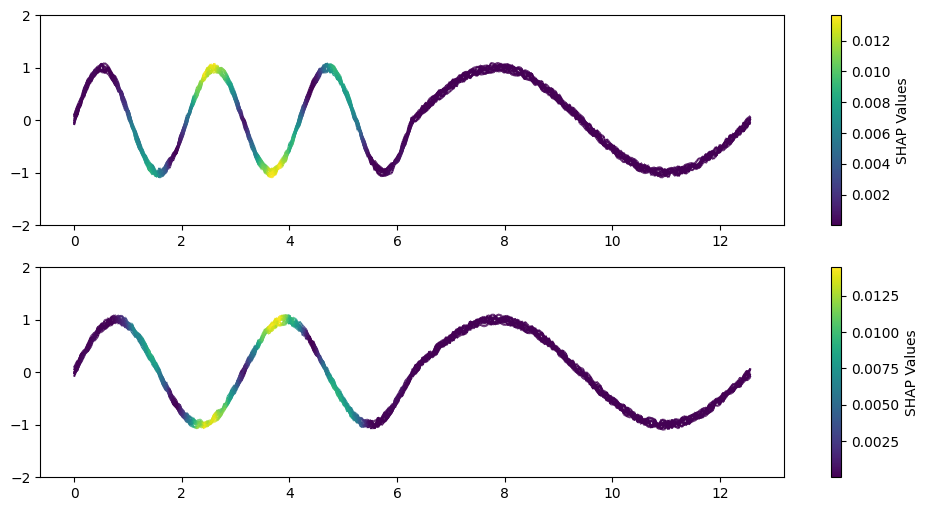

In [23]:
from  tsproto.plots import plot_smooth_colored_line
indexer = clf.predict(trainX)
shapclass = []
if absshap == False:
    for i in range(0,len(trainX)):
        best_index = indexer[i]
        shapclass.append([sv_tr[best_index][i,:]])

    shapclass=np.concatenate(shapclass)
else:
    shapclass  = sv_tr[:,0,:]

    fig, axes =plt.subplots(2,1,figsize=(12,6))

    for i in range(0,10):
        plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==0][i], color_values=shapclass[train_y==0][i], resolution=1000, ax=axes[0],add_cbar=(i==0))
        plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==1][i], color_values=shapclass[train_y==1][i], resolution=1000, ax=axes[1],add_cbar=(i==0))

for ax in axes:
    ax.set_ylim([-2, 2])

In [24]:
## TEST breakpoints
import ruptures as rpt
pen=1
totalbpoints=[]
for i in range(0, trainX.shape[0]):
    algo = rpt.Pelt(model='l2', min_size=5, jump=1).fit(shapclass[i])

    try:
        breakpoints = algo.predict(pen=(0.25*trainX.shape[1])**(1-pen)*2*np.log(trainX.shape[1]))
        print(f'No bkps for pen: {(0.25*trainX.shape[1])**(1-pen)*2*np.log(trainX.shape[1])}: {len(breakpoints)}')
    except:
        # no change detected, means there are no breakpoints
        print('kk)')
        breakpoints = [0]
    totalbpoints.append(breakpoints)

No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.596634733096073: 1
No bkps for pen: 10.59663

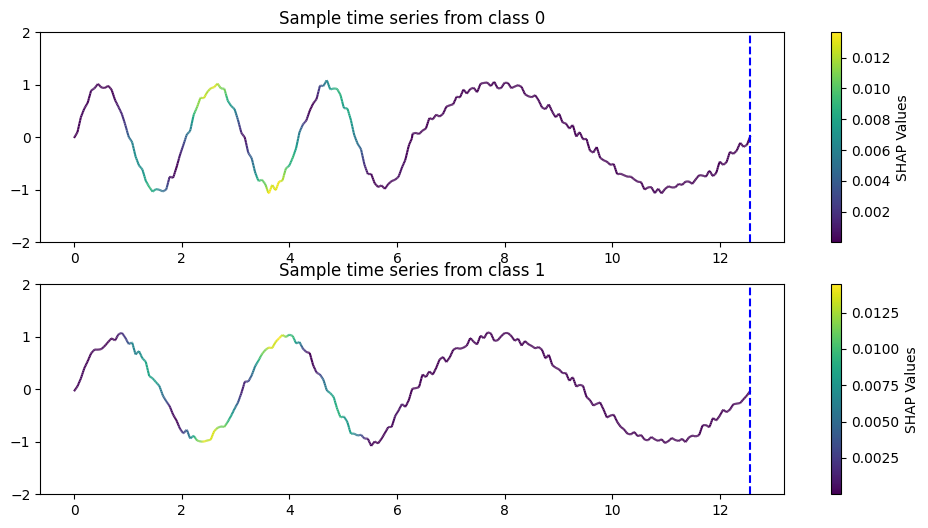

In [25]:
from tsproto.plots import plot_smooth_colored_line
import seaborn as sns

tbp = pd.DataFrame(totalbpoints)


fig, axes =plt.subplots(2,1,figsize=(12,6))
for i in range(0,1):
    bkp0 = x[tbp[train_y==0].iloc[i].dropna().astype(int)-1]
    bkp1 =x[tbp[train_y==1].iloc[i].dropna().astype(int)-1]
    plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==0][i], color_values=shapclass[train_y==0][i], resolution=1000, ax=axes[0],add_cbar=(i==0))

    for b in bkp0:
        axes[0].axvline(x=b, color='b', linestyle='--')

    plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==1][i], color_values=shapclass[train_y==1][i], resolution=1000, ax=axes[1],add_cbar=(i==0))
    for b in bkp1:
        axes[1].axvline(x=b, color='b', linestyle='--')

for ax in axes:
    ax.set_ylim([-2, 2])

axes[0].set_title('Sample time series from class 0')
axes[1].set_title('Sample time series from class 1')
plt.savefig('c1c2shap.svg', format='svg',bbox_inches='tight')

## Tsproto
Now, lets try to apply TSProto to see if it is able to find the prototype and summarize them correctly to show what logical relation is between them and the model prediction

In [26]:
trainXproto = trainX.reshape((trainX.shape[0], trainX.shape[1],1))
shapclassXproto = shapclass.reshape((shapclass.shape[0], shapclass.shape[1],1))

In [27]:
from tsproto.models import *
im  = InterpretableModel()
pe = PrototypeEncoder(clf, n_clusters=2, min_size=50, method='dtw',
                              descriptors=['frequency'],
                      jump=1, pen=1,multiplier=-1,n_jobs=-1,
                      verbose=1)
ohe_train, features, target_ohe,weights = pe.fit_transform(trainXproto,shapclassXproto)
acc,prec,rec,f1,iclf = im.fit_or_predict(ohe_train, features, target_ohe,intclf=None, verbose=0, max_depth=2, min_samples_leaf=0.05,
                       weights=None)


Dataset shape: (150, 200, 1)
Calculating changepoints...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Done in 2.0875487327575684.
Clustering data
Shape of data for clustering: (150, 86, 1)
Clustering data
Done in 9.194103479385376.
OHE time series
['frequency']
Done in 0.5474450588226318.


## Visualize interpretable model
We can easily see that the TSProto has found the sine wave at the beginning of the sample, marked it as prototype and correctly identified that its existence is not enough to treat the sample as a class 1 sample, additional frequency context has to be added in order to distinguish these two

TC: 77 over ccshap: 77
Number of clusters in opposite_class: [77] as opposed ot actual class [0]


/usr/local/lib/python3.12/dist-packages/tsproto/plots.py:274: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[-1].legend()


Decision Tree exported to synthetic with embedded histograms successfully.


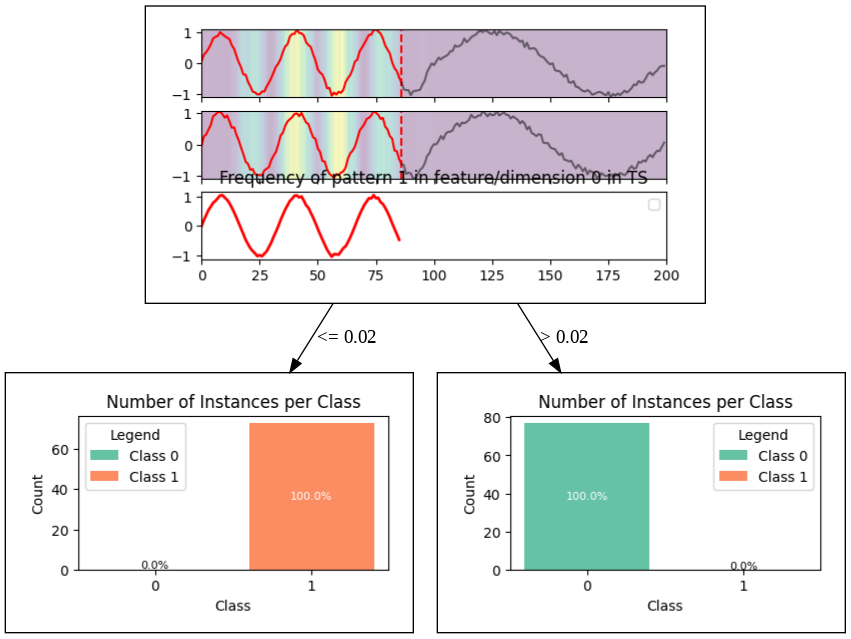

In [28]:
from  tsproto.plots import *
ds_final = ohe_train.copy()
dot = export_decision_tree_with_embedded_histograms(decision_tree=iclf,
                                              dataset=ds_final,
                                              target_name='target',
                                              feature_names=features,
                                              filename='synthetic',
                                              focus_class=1,
                                              proto_encoder=pe, figsize=(6,3))

from IPython.display import SVG, Image
Image('synthetic.png')